# Project: Customer Churn Prediction

#### Author: Adrieli Dal'Toé

**Main Goal**. In this project, I will train a logistic regression model to predict churn for a telecommunications provider based on the data set available at https://www.kaggle.com/c/customer-churn-prediction-2020/overview/description.

## Import libraries

In [1]:
# Data Manipulation and visualization
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Disable warnings
import warnings
warnings.filterwarnings('ignore')

# Hypothesis test
from scipy.stats import chi2_contingency
from scipy.stats import shapiro
from scipy.stats import levene
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from scipy.stats import kstest
from statsmodels.stats.power import TTestIndPower

# Pre-processing and machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

# Model interpretability
import shap

# ROC and PR curves
from custom_functions.functions import prc_plot, roc_plot

In [2]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Adrieli Dal'Toé" --iversions

Author: Adrieli Dal'Toé

matplotlib: 3.3.4
shap      : 0.39.0
numpy     : 1.19.2
seaborn   : 0.11.1
plotly    : 4.9.0
pandas    : 1.2.3
re        : 2.2.1



In [3]:
import plotly.io as pio
pio.renderers.default='notebook_connected'

## Loading the train set

In [4]:
# Import train set
df_train = pd.read_csv('projeto4_telecom_treino.csv')
df_train.drop(columns = 'Unnamed: 0', inplace = True)

In [5]:
df_train.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,KS,128,area_code_415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,no
1,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
2,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
3,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
4,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no


#### Data Dictionary

1. "state", string. 2-letter code of the US state of customer residence
2. "account_length", numerical. Number of months the customer has been with the current telco provider
3. "area_code", string="area_code_AAA" where AAA = 3 digit area code.
4. "international_plan", boolean. The customer has international plan.
5. "voice_mail_plan", boolean. The customer has voice mail plan.
6. "number_vmail_messages", numerical. Number of voice-mail messages.
7. "total_day_minutes", numerical. Total minutes of day calls.
8. "total_day_calls", numerical. Total days with calls.
9. "total_day_charge", numerical. Total charge of day calls.
10. "total_eve_minutes", numerical. Total minutes of evening calls.
11. "total_eve_calls", numerical. Total number of evening calls.
12. "total_eve_charge", numerical. Total charge of evening calls.
13. "total_night_minutes", numerical. Total minutes of night calls.
14. "total_night_calls", numerical. Total number of night calls.
15. "total_night_charge", numerical. Total charge of night calls.
16. "total_intl_minutes", numerical. Total minutes of international calls.
17. "total_intl_calls", numerical. Total number of international calls.
18. "total_intl_charge", numerical. Total charge of international calls
19. "number_customer_service_calls", numerical. Number of calls to customer service
20. "churn", boolean. Customer churn - target variable.

I will add 2 new columns, state name and interstate region, in order to ease the understanding of the data.

In [6]:
# Add the name of the states and interstate regions of USA
# https://en.wikipedia.org/wiki/List_of_regions_of_the_United_States

regions = {'Northeast': 'Connecticut, Maine, Massachusetts, New Hampshire, Rhode Island, Vermont, New Jersey, New York, Pennsylvania'.split(','),
 'South': 'Delaware, Florida, Georgia, Maryland, North Carolina, South Carolina, Virginia, District of Columbia, West Virginia, Alabama, Kentucky, Mississippi, Tennessee, Arkansas, Louisiana, Oklahoma, Texas, '.split(','),
 'Midwest': 'Illinois, Indiana, Michigan, Ohio, Wisconsin, Iowa, Kansas, Minnesota, Missouri, Nebraska, North Dakota, South Dakota'.split(','),
 'West': 'Arizona, Colorado, Idaho, Montana, Nevada, New Mexico, Utah, Wyoming, Alaska, California, Hawaii, Oregon, Washington'.split(',')
}

# Organizing the data
lk = []
lv = []
for k,v in regions.items():
    count = len(regions[k])
    lk.append([k]*count)
    lv.append(regions[k])

region = [item for sublist in lk for item in sublist]
state = [item for sublist in lv for item in sublist]

# Creating a dataframe and removing extra spaces
regionState = pd.DataFrame({'region':region, 'state':state})
regionState['state'] = regionState['state'].apply(lambda x: x.strip()).values

# Import dataframe with name of the states and their postal code
stateAbbr = pd.read_csv('statesAbbr.csv')

# Merging regionStte and StateAbbr together
regionAbbr = stateAbbr.merge(right=regionState,left_on='State/District',right_on='state', how='left')
regionAbbr.drop(columns=['state','Abbreviation'],inplace=True)

# Merging with df_train
df_train = df_train.merge(right=regionAbbr,how='left',left_on='state',right_on='Postal Code').drop(columns='Postal Code')\
                .rename(columns={'State/District':'state_name'})


## 1. Exploratory Data Analysis

In [7]:
df_train.shape

(3333, 22)

In [8]:
# Data types.
df_train.dtypes

state                             object
account_length                     int64
area_code                         object
international_plan                object
voice_mail_plan                   object
number_vmail_messages              int64
total_day_minutes                float64
total_day_calls                    int64
total_day_charge                 float64
total_eve_minutes                float64
total_eve_calls                    int64
total_eve_charge                 float64
total_night_minutes              float64
total_night_calls                  int64
total_night_charge               float64
total_intl_minutes               float64
total_intl_calls                   int64
total_intl_charge                float64
number_customer_service_calls      int64
churn                             object
state_name                        object
region                            object
dtype: object

In [9]:
print('Number of numeric columns')
print(df_train.select_dtypes(include=['float64','int64']).shape[1])
print('Number of categorical columns')
print(df_train.select_dtypes(include=['object']).shape[1])

Number of numeric columns
15
Number of categorical columns
7


In [10]:
# No missing data
df_train.isna().sum()

state                            0
account_length                   0
area_code                        0
international_plan               0
voice_mail_plan                  0
number_vmail_messages            0
total_day_minutes                0
total_day_calls                  0
total_day_charge                 0
total_eve_minutes                0
total_eve_calls                  0
total_eve_charge                 0
total_night_minutes              0
total_night_calls                0
total_night_charge               0
total_intl_minutes               0
total_intl_calls                 0
total_intl_charge                0
number_customer_service_calls    0
churn                            0
state_name                       0
region                           0
dtype: int64

### 1.1 Exploring Non-Numerical Columns

In [11]:
df_nonNumeric = df_train.select_dtypes(include=['object']).copy()
df_nonNumeric.head()

,state,area_code,international_plan,voice_mail_plan,churn,state_name,region
0,KS,area_code_415,no,yes,no,Kansas,Midwest
1,OH,area_code_415,no,yes,no,Ohio,Midwest
2,NJ,area_code_415,no,no,no,New Jersey,Northeast
3,OH,area_code_408,yes,no,no,Ohio,Midwest
4,OK,area_code_415,yes,no,no,Oklahoma,South


#### 1.1.1 Proportion of churn

In [12]:
churn = df_train['churn'].value_counts(normalize = True)

fig = px.pie(values=churn.values, names=churn.index, title='Proportion of Churn.',
             color_discrete_sequence=px.colors.qualitative.D3)
fig.show()

#### 1.1.2 How many customers are there in each state?

In [13]:
n_customers = df_nonNumeric.groupby(['state','state_name'])['churn'].count().reset_index().rename(columns={'churn':'Customers'})
n_customers['%'] = n_customers['Customers']*100/n_customers['Customers'].sum()
us_map = px.choropleth(data_frame = n_customers,
                       locationmode ='USA-states',
                       locations = 'state',
                       scope = 'usa',
                       color = '%',
                       color_continuous_scale = 'blues',
                       hover_name="state_name",
                      title = 'Customers by State.')
us_map.show()

California, Iowa and Pennsylvania are the three states with less customers; and West Virginia has the larger amount of customers.

#### 1.1.3 Churn by state

In [14]:
churn_state = df_nonNumeric.groupby(['state','state_name'])['churn'].value_counts().to_frame()\
                            .rename(columns={'churn':'count'}).reset_index()

churn_state['%'] = df_nonNumeric.groupby('state')['churn'].value_counts(normalize=True).values*100

us_map = px.choropleth(data_frame = churn_state[churn_state['churn']=='yes'],
                       locationmode ='USA-states',
                       locations = 'state',
                       scope = 'usa',
                       color = '%',
                       color_continuous_scale = 'solar_r',
                       hover_name = 'state_name',
                      title = 'Churn rate by State.')
us_map.show()

California, New Jersey, Texas and Maryland are the four states with the largest churn rate. With the exception of California, churn rate is not directly related with the amount of customers, i.e., states that have less customers do not necessarily have the higher churn rates and vice versa. This is clearly shown in the next visualization, where the states are ordered according to the amount of customers. It is seen that the percentage of churn varies with no specific pattern when data is ordered by the number of customers. 

In [15]:
fig = px.bar(churn_state.sort_values(by='count',ascending=False), x="state", y="%", color="churn", 
             title="Churn rate by State.",color_discrete_sequence=px.colors.qualitative.D3, hover_name="state_name")

fig.add_shape(type="line",
    x0=-0.5, y0=73.5294, x1=50.5, y1=73.5294,
    line=dict(color="DarkOrange",width=3, dash="dashdot"))

fig.add_annotation(x=3, y=66,
            text="<b>Max churn rate</b>",bgcolor="white",
            showarrow=False,
            yshift=10)

fig.update_layout(legend_traceorder="reversed")

fig.show()

#### Is churn associated with state?

In [16]:
contingency_tab = pd.crosstab(index = df_nonNumeric['state'],columns = df_nonNumeric['churn'])

In [17]:
# Chi-squared test of independency

# H0: the two variables are independent. If p-value <= 0.05, reject H0.
# H1: the two variables are dependent. If p-value > 0.05, fail to reject H0.

_, p_value, _, expctd = chi2_contingency(contingency_tab)
print('p-value: ',p_value,'\n')

p-value:  0.002296221552011188 



Considering the chi-squared test, there is enough evidence to reject the null hypothesis, i.e. the churn is associated with state. 

#### 1.1.4 Is churn associated with area_code?

In [18]:
# Area code 415 is more frequent
df_nonNumeric['area_code'].value_counts()

area_code_415    1655
area_code_510     840
area_code_408     838
Name: area_code, dtype: int64

In [19]:
# Area_code by region. Area 415 is predominant in all the interstate regions.
df_nonNumeric.groupby(['region'])['area_code'].value_counts(normalize=True).unstack()

area_code,area_code_408,area_code_415,area_code_510
region,,,
Midwest,0.239401,0.497506,0.263092
Northeast,0.275804,0.478849,0.245347
South,0.254283,0.491434,0.254283
West,0.241877,0.515042,0.243081


Let's evaluate the proportion of area code in each state.

In [20]:
areaCode_state = df_nonNumeric.groupby(['state','state_name'])['area_code'].value_counts(normalize=True).to_frame()\
                .rename(columns={'area_code':'count'}).reset_index().sort_values(by='count',ascending=False)

fig = px.bar(areaCode_state, x="count", y= "state",
             color='area_code',
             color_discrete_sequence=['#855c75','#888888','#a5aa99'], hover_name="state_name",
             height=700, labels=dict(count="Proportion of customers"), title="Area code by State.")

fig.update_layout(showlegend=True)

fig.show()

It is noticeable that all states share the 3 area codes, but area code 415 is predominant in almost all the states, except on New Hampshire (NH), where area code 408 is predominant. Now let's see the churn rate by area code.

In [21]:
area_codeData = df_nonNumeric.groupby(['area_code','state', 'churn'])['state_name'].count().reset_index()

fig = px.box(area_codeData, x="area_code", y="state_name", color='churn', color_discrete_sequence=px.colors.qualitative.D3,
            labels=dict(state_name=" ",area_code=" "))
fig.update_layout(legend_traceorder="reversed")
fig.show()

In general, the proportion of churn is higher for area code 415. Let's see if these differences are statistically significant.

In [22]:
contingency_tab = pd.crosstab(index = df_nonNumeric['churn'],columns = df_nonNumeric['area_code'])
contingency_tab

area_code,area_code_408,area_code_415,area_code_510
churn,,,
no,716,1419,715
yes,122,236,125


In [23]:
# Chi-squared test of independency

# H0: the two variables are independent. If p-value <= 0.05, reject H0.
# H1: the two variables are dependent. If p-value > 0.05, fail to reject H0.

_, p_value, _, expctd = chi2_contingency(contingency_tab)
print('p-value: ',np.round(p_value,2),'\n')
print('Table of expected values if variables were independent: \n', np.round(expctd))

p-value:  0.92 

Table of expected values if variables were independent: 
 [[ 717. 1415.  718.]
 [ 121.  240.  122.]]


According to chi-square test, churn is independent of the area_code under a significance level of 5%. Thus, the differences observed before are not statistically significant.

#### 1.1.5 Churn by interstate region.

In [24]:
# Customers by region
custRegion=df_nonNumeric.groupby(['region'])['churn'].count().reset_index().rename(columns={'churn':'customers'})
custRegion['customers']=np.round(custRegion['customers']*100/custRegion['customers'].sum(),2)

# Churn by region
churnRegion = df_nonNumeric.groupby(['region'])['churn'].value_counts(normalize=True).to_frame()\
                .rename(columns={'churn':'percentage'}).reset_index()

from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=1, cols=2, subplot_titles=("Customers by Region", "Churn by Region"))

fig.add_trace(go.Bar(x=custRegion['region'], y=custRegion['customers'],
                    marker=dict(color=['gray']*4)),1,1)

fig.add_trace(go.Bar(x=churnRegion[churnRegion['churn']=='yes']['region'],
                    y=churnRegion[churnRegion['churn']=='yes']['percentage'],
                    marker=dict(color="#FF7F0E")),1,2)#

fig.update_layout(showlegend=False)

fig.show()

Northeast has less customers than the other regions, but has the largest churn rate. Is this difference statistically significant?

In [25]:
contingency_tab = pd.crosstab(index = df_nonNumeric['churn'],columns = df_nonNumeric['region'])
contingency_tab

region,Midwest,Northeast,South,West
churn,,,,
no,698,491,945,716
yes,104,100,164,115


In [26]:
# Chi-squared test of independency

# H0: the two variables are independent. If p-value <= 0.05, reject H0.
# H1: the two variables are dependent. If p-value > 0.05, fail to reject H0.

_, p_value, _, expctd = chi2_contingency(contingency_tab)
print('p-value: ',np.round(p_value,2),'\n')
print('Table of expected values if variables were independent: \n', np.round(expctd))

p-value:  0.2 

Table of expected values if variables were independent: 
 [[686. 505. 948. 711.]
 [116.  86. 161. 120.]]


According to chi-squared test there is not enough evidence to reject the null hypothesis that states the variables are independent of each other. In this case, region does not help to predict churn, so it is not an important feature to the model.

#### 1.1.6 Having an international plan affects Churn?

In [27]:
contingency_tab = pd.crosstab(index = df_nonNumeric['churn'],columns = df_nonNumeric['international_plan'])
contingency_tab

international_plan,no,yes
churn,,
no,2664,186
yes,346,137


In [28]:
# Chi-squared test of independency

# H0: the two variables are independent. If p-value <= 0.05, reject H0
# H1: the two variables are dependent. If p-value > 0.05, fail to reject H0

_, p_value, _, expctd = chi2_contingency(contingency_tab)
print('p-value: ',p_value,'\n')
print('Table of expected values if variables were independent: \n', expctd)

p-value:  2.4931077033159556e-50 

Table of expected values if variables were independent: 
 [[2573.80738074  276.19261926]
 [ 436.19261926   46.80738074]]


Chi-squared test indicates an association between churn and international_plan, and this feature might be important to the model. Having an international plan influences the churn rate, because we would expect apprx. 47 customers to churn if the features were independent, but there are 137. 

The next summary shows the conditional probability of churn given that a customer has an international plan or not. It is noticed that the probability of churn given that the customer has an international plan is 42%, while the probability of churn without an international plan is only 11%.

In [29]:
df_nonNumeric.groupby('international_plan')['churn'].value_counts(normalize=True)

international_plan  churn
no                  no       0.885050
                    yes      0.114950
yes                 no       0.575851
                    yes      0.424149
Name: churn, dtype: float64

In [30]:
# The relative risk and odds ratio
rel_risk_churn = (contingency_tab['yes']['yes']/sum(contingency_tab['yes']))/(contingency_tab['no']['yes']/sum(contingency_tab['no']))
rel_risk_no_churn = (contingency_tab['yes']['no']/sum(contingency_tab['yes']))/(contingency_tab['no']['no']/sum(contingency_tab['no']))
odds_ratio = rel_risk_churn / rel_risk_no_churn

print('The proportion of individuals that churn is {} higher among those with an international plan.'\
      .format(np.round(rel_risk_churn,2)))
print('In contrast, the proportion of individuals that churn is {} smaller among those without an international plan.'\
      .format(np.round(rel_risk_no_churn,2)))
print('The odds ratio of a customer churn is {} higher when customer has an international plan.'\
     .format(np.round(odds_ratio,2)))

The proportion of individuals that churn is 3.69 higher among those with an international plan.
In contrast, the proportion of individuals that churn is 0.65 smaller among those without an international plan.
The odds ratio of a customer churn is 5.67 higher when customer has an international plan.


This result is very interesting and it might indicate that improvements must be done in the international plan. Moreover, international_plan seems to be an important feature to predict churn.

#### 1.1.7 Having a voicemail plan affects churn?

In [31]:
contingeny_tab1 = pd.crosstab(index = df_nonNumeric['churn'],columns = df_nonNumeric['voice_mail_plan'])
contingeny_tab1

voice_mail_plan,no,yes
churn,,
no,2008,842
yes,403,80


In [32]:
# Chi-squared test of independency

# H0: the two variables are independent. If p-value <= 0.05, reject H0
# H1: the two variables are dependent. If p-value > 0.05, fail to reject H0

_, p_value, _, expctd = chi2_contingency(contingeny_tab1)
print('p-value: ',p_value,'\n')
print('Table of expected values if variables were independent: \n', expctd)

p-value:  5.15063965903898e-09 

Table of expected values if variables were independent: 
 [[2061.61116112  788.38883888]
 [ 349.38883888  133.61116112]]


We can see that having a voicemail plan affects churn, but in the opposite way to that observed when there was an international plan. Now, less customers have left the company when they had a voicemail plan. Note that 133 customers were expected to leave the company, but only 80 left when they had the voicemail plan.

In the summary below, we notice that only 9% of customers churn when having a voicemail plan, while 17% churn without this plan. 

In [33]:
df_nonNumeric.groupby('voice_mail_plan')['churn'].value_counts(normalize=True)

voice_mail_plan  churn
no               no       0.832849
                 yes      0.167151
yes              no       0.913232
                 yes      0.086768
Name: churn, dtype: float64

In [34]:
# The relative risk and odds ratio
rel_risk_churn = (contingeny_tab1['yes']['yes']/sum(contingeny_tab1['yes']))/(contingeny_tab1['no']['yes']/sum(contingeny_tab1['no']))
rel_risk_no_churn = (contingeny_tab1['yes']['no']/sum(contingeny_tab1['yes']))/(contingeny_tab1['no']['no']/sum(contingeny_tab1['no']))
odds_ratio = rel_risk_churn / rel_risk_no_churn

print('The proportion of individuals that churn is {} smaller among those with a voicemail plan.'\
      .format(np.round(rel_risk_churn,2)))
print('In contrast, the proportion of individuals that churn is {} higher among those without a voicemail plan.'\
      .format(np.round(rel_risk_no_churn,2)))
print('The odds ratio of a customer churn is {} times smaller when customer has a voicemail plan.'\
     .format(np.round(odds_ratio,2)))

The proportion of individuals that churn is 0.52 smaller among those with a voicemail plan.
In contrast, the proportion of individuals that churn is 1.1 higher among those without a voicemail plan.
The odds ratio of a customer churn is 0.47 times smaller when customer has a voicemail plan.


It seems that customers are satisfied with the voicemail plan, once individuals in this group churn less. The data also provides the number of voicemail messages. Let's check if there is difference between the average of voicemail messages for customers that churn and do not churn.

#### Is the average voicemail messages different among customers that churn?

In [35]:
# Distribution of the number of voicemail messages
vmail_messages = df_train[df_train['voice_mail_plan']=='yes'][['number_vmail_messages','churn']]
fig = px.box(vmail_messages, x="churn", y="number_vmail_messages", color='churn',
             color_discrete_sequence=px.colors.qualitative.D3, points='all')
fig.update_layout(showlegend=False)
fig.show()

#### T-test for the means of two independent samples

Based on the boxplots above, I want to test if the mean number of vmail messages is greater in the group that churn (g_churn) compared to the group that do not churn (g_not_churn). Then, the hypothesis will be:

1. H0: the mean voice messages are the same. If p-value <= 0.05, H0 is rejected.
2. H1: the mean voice messages of g_churn is greater than that of g_not_churn.

T-test assumes two conditions: 1) samples are normally distributed and 2) homogeneous variance between the groups. Let's evaluate these conditions and, then, apply t-test.

In [36]:
g_churn = vmail_messages[vmail_messages['churn']=='yes']['number_vmail_messages']
g_not_churn = vmail_messages[vmail_messages['churn']=='no']['number_vmail_messages']

In [37]:
# Shapiro-Wilk test for normality
# H0: data follows a normal distribution. If p-value <= 0.05, H0 is rejected.
# H1: data do not follow a normal distribution
_, p_value1 = shapiro(g_churn)
_, p_value2 = shapiro(g_not_churn)
if p_value1 > 0.05 and p_value2 > 0.05:
    dist = 'normal'
    print('Both groups follow a normal distribution. g_churn p-value: {}. sample_g_not_churn p-value: {}'\
          .format(np.round(p_value1,4), np.round(p_value2,4)))
else:
    dist = 'NotNormal'
    print('Groups do not follow a normal distribution.')

Both groups follow a normal distribution. g_churn p-value: 0.3541. sample_g_not_churn p-value: 0.2238


In [38]:
# Size of each sample
vmail_messages.groupby('churn')['number_vmail_messages'].count()

churn
no     842
yes     80
Name: number_vmail_messages, dtype: int64

The sizes of the samples are very different, the proportion is 10:1. In this condition, t-test is only valid if the variance of both groups are equal, otherwise Welch's t-test must be used. Let's use Levene test to evaluate the variance.

In [39]:
# Levene test
# H0: the variances are equal. If p-value <= 0.05, reject H0
# H1: the variances are unequal.
_, p_valueV = levene(g_churn,g_not_churn)
if p_valueV > 0.05:
    print('Both groups have identical variance, p-value: ', np.round(p_valueV,4))

Both groups have identical variance, p-value:  0.3956


According to Levene's test, the variances are equal. So, I'm going to perform a t-test and a welch's t-test, in case I have committed a type II error, accepting H0 being it false.

In [40]:
# T-test of two independent groups
_, p_value = ttest_ind(g_churn,g_not_churn, alternative='greater')
if p_value <= 0.05:
    print('T-test - g_churn have a greater avegare than g_not_churn, p-value = ', np.round(p_value,4))
else:
    print('T-test - Average of g_churn is not greater than g_not_churn, p-value = ', np.round(p_value,4))

# Welch's t-test
_, p_value = ttest_ind(g_churn,g_not_churn, equal_var = False, alternative='greater')
if p_value <= 0.05:
    print("Welch's t-test - g_churn have a greater avegare than g_not_churn, p-value = ", np.round(p_value,4))
else:
    print("Welch's t-test - Average of g_churn is not greater than g_not_churn, p-value = ", np.round(p_value,4))

T-test - g_churn have a greater avegare than g_not_churn, p-value =  0.0231
Welch's t-test - g_churn have a greater avegare than g_not_churn, p-value =  0.0202


Both t-test and Welch's t-tests resulted in similar p-values, thus, the null hypothesis is rejected and the alternative hypothesis, which states that the mean number of voicemails are greater in g_churn, is accepted. But, what is the probability of this true positive result? In other words, what is the probability of making a type II error, accept H1 given that H0 is true. A power analysis gives the answer.

In [41]:
# parameters for power analysis
effect_size = (g_churn.mean() - g_not_churn.mean()) / vmail_messages.std()
ratio = g_not_churn.shape[0]/g_churn.shape[0]

# perform power analysis
analysis = TTestIndPower()
result = analysis.solve_power(effect_size[0], power=None, nobs1=80, ratio=ratio, alpha=0.05, alternative='larger')
print('Power analysis: %.3f' % result)

Power analysis: 0.636


In [42]:
n_sample1 = analysis.solve_power(effect_size[0], power=0.9, nobs1=None, ratio=ratio, alpha=0.05, alternative='larger')
print('The sample size of the smaller group should be {} to have a power of 90%.'.format(np.round(n_sample1)))

The sample size of the smaller group should be 173.0 to have a power of 90%.


Thus, there is a probability of 63.6% that the test correctly rejected H0 if H1 is true. It is a good idea to collect more data for g_churn group, in order to increase the power of the test.

#### 1.1.8 Strengh of association matrix

Let's use Cramer's V to estimate the strengh of association among the categorical variables.

In [43]:
def cramers_corrected_stat(x,y):

    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    result=-1
    if len(x.value_counts())==1 :
        print("First variable is constant")
    elif len(y.value_counts())==1:
        print("Second variable is constant")
    else:   
        conf_matrix=pd.crosstab(x, y)

        if conf_matrix.shape[0]==2:
            correct=False
        else:
            correct=True
        
        # Chi2 statistics
        chi2 = chi2_contingency(conf_matrix, correction=correct)[0]

        n = sum(conf_matrix.sum())
        phi2 = chi2/n
        r,k = conf_matrix.shape
        # Bias correction
        phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
        rcorr = r - ((r-1)**2)/(n-1)
        kcorr = k - ((k-1)**2)/(n-1)
        result=np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))
    return round(result,6)

In [44]:
columns = ['state', 'area_code', 'international_plan', 'voice_mail_plan', 'region', 'churn']

values = {}
for i,col1 in enumerate(columns):
    key = col1
    values[key] = []
    for col2 in columns:
        cramer = cramers_corrected_stat(df_nonNumeric[col1],df_nonNumeric[col2])
        values[key].append(cramer)

In [45]:
fig = px.imshow(pd.DataFrame(values, index=columns), color_continuous_scale='blues')
fig.show()

international_plan presented the strongest association with churn, followed by voice_mail_plan and state. The association is weak though, ranging from 0.1 to 0.26. Considering the other variables, only state and region presented a strong correlation, which makes sense, because each state belongs to only 1 specific region.

### 1.2. Exploring Numeric Columns

In [46]:
df_numeric = df_train.select_dtypes(include=['float64','int64']).copy()

In [47]:
df_numeric.nunique()

account_length                    212
number_vmail_messages              46
total_day_minutes                1667
total_day_calls                   119
total_day_charge                 1667
total_eve_minutes                1611
total_eve_calls                   123
total_eve_charge                 1440
total_night_minutes              1591
total_night_calls                 120
total_night_charge                933
total_intl_minutes                162
total_intl_calls                   21
total_intl_charge                 162
number_customer_service_calls      10
dtype: int64

In [48]:
# Add the churn column
df_numeric['churn']=df_train['churn']

#### 1.2.1 When customers cancel the service?

Let's evaluate the distribution of account_length for each churn category (yes and no).

In [49]:
fig = px.box(df_numeric, x="churn", y="account_length", color='churn', points='all',
             color_discrete_sequence=px.colors.qualitative.D3,labels=dict(account_length="Account length"))
fig.update_layout(showlegend=False)
fig.show()

It seems that there is no difference between people that churn and those who stay in the company considering account_length. Also, there is no outliers in neither of the groups.

In [50]:
df_numeric.groupby('churn')['account_length'].describe()

,count,mean,std,min,25%,50%,75%,max
churn,,,,,,,,
no,2850.0,100.793684,39.88235,1.0,73.0,100.0,127.0,243.0
yes,483.0,102.664596,39.46782,1.0,76.0,103.0,127.0,225.0


In [51]:
# Shapiro-Wilk test for normality

g_churn = df_train[df_train['churn']=='yes']['account_length']
g_not_churn = df_train[df_train['churn']=='no']['account_length']

# H0: data follows a normal distribution. If p-value <= 0.05, H0 is rejected.
# H1: data do not follow a normal distribution
_, p_value1 = shapiro(g_churn)
_, p_value2 = shapiro(g_not_churn)
print('p-value g_churn: ', p_value1)
print('p-value g_not_churn: ', p_value2)

p-value g_churn:  0.4565553665161133
p-value g_not_churn:  0.004041680134832859


In [52]:
print('g_churn group')
print('Skewness: {}, kurtosis: {}'.format(np.round(g_churn.skew(),3), np.round(g_churn.kurtosis(),3)))
print('g_not_churn group')
print('Skewness: {}, kurtosis: {}'.format(np.round(g_not_churn.skew(),3), np.round(g_not_churn.kurtosis(),3)))

g_churn group
Skewness: 0.137, kurtosis: 0.057
g_not_churn group
Skewness: 0.091, kurtosis: -0.134


According to Shapiro test, the account length of churn group follows a normal distribution, while the group that do not churn follows a non-normal distribution, despite its pretty low skewness of 0.091. However, Nguyen et al. 2016 showed in their study that the independent means t-test performed very well on Type I error control when the homogeneity assumption was met regardless of the tenability of the normality assumption. Furthermore, the authors recommended use independent t-test if homocedasticity is met, even if the sample sizes are unequal.

Reference: https://digitalcommons.wayne.edu/cgi/viewcontent.cgi?article=1852&context=jmasm

In [53]:
# T-test of two independent groups

# Levene test
# H0: the variances are equal. If p-value <= 0.05, reject H0
# H1: the variances are unequal.
_, p_valueV = levene(g_churn,g_not_churn)
if p_valueV > 0.05:
    print('Both groups have identical variance, p-value: ', np.round(p_valueV,3))

print('T-test')
_, p_value = ttest_ind(g_churn,g_not_churn,equal_var=True,alternative='two-sided')
if p_value <= 0.05:
    print('Averages are different, p-value = ', np.round(p_value,3))
else:
    print('Averages are equal, p-value = ', np.round(p_value,3))

Both groups have identical variance, p-value:  0.521
T-test
Averages are equal, p-value =  0.34


#### 1.2.2 Is there a relationship between the frequency customers need support and churn?

In [54]:
# boxplots
fig = px.box(df_numeric, x="churn", y="number_customer_service_calls", color='churn', 
             color_discrete_sequence=px.colors.qualitative.D3,
             labels=dict(number_customer_service_calls="Number of service calls"))
fig.update_layout(showlegend=False)
fig.show()

From the boxplots, it is noticed that the number of service calls in the churn group is more spread out compared to not churn group, i.e, the churn group demands more customer service. A supposition here is that these customers had a problem that was not solved, even after repeated calls to the customer service and cancelled the service by insatisfaction.

**Description for not churn group boxplot**: It is seen that 50% of the customer called 1 or 0 times the customer service. The interquantile range is 1, and the number of calls above 3 is considered outliers, due to the higher frequency of 0, 1 and 2 calls. The median for this group is 1 service call.

**Description for churn group boxplot**: 50% of the customer in this group had until 2 service calls. The interquantile range is 3, and, in this case, only number of calls above 8 was considered outlier, a direct indication of the higher variability in this group. The median is 2.

Since these groups do not follow a normal distribution, the Mann Whitney U Test (also called Wilcoxon rank-sum test) is going to be used to test the differences between the medians of the two groups.

In [55]:
# H0: the medians of the distributions are the same  
# H1: the median of the g_chunr is greater than g_not_churn

g_churn = df_numeric[df_numeric['churn']=='yes']['number_customer_service_calls']
g_not_churn = df_numeric[df_numeric['churn']=='no']['number_customer_service_calls']
stat, p_value = mannwhitneyu(g_churn, g_not_churn, alternative='greater')

if p_value <= 0.05:
    print('g_churn group median is greater than the median of g_not_churn under statistical significance ' \
          'of 5%, p_value: {:.2e}'.format(p_value))

g_churn group median is greater than the median of g_not_churn under statistical significance of 5%, p_value: 1.53e-15


The probability of an observation from population g_churn exceeding an observation from population g_not_churn is greater than the probability of an observation from g_not_churn exceeding an observation from g_churn.

#### 1.2.3 Evaluation of total call duration, total number of calls and total charge.

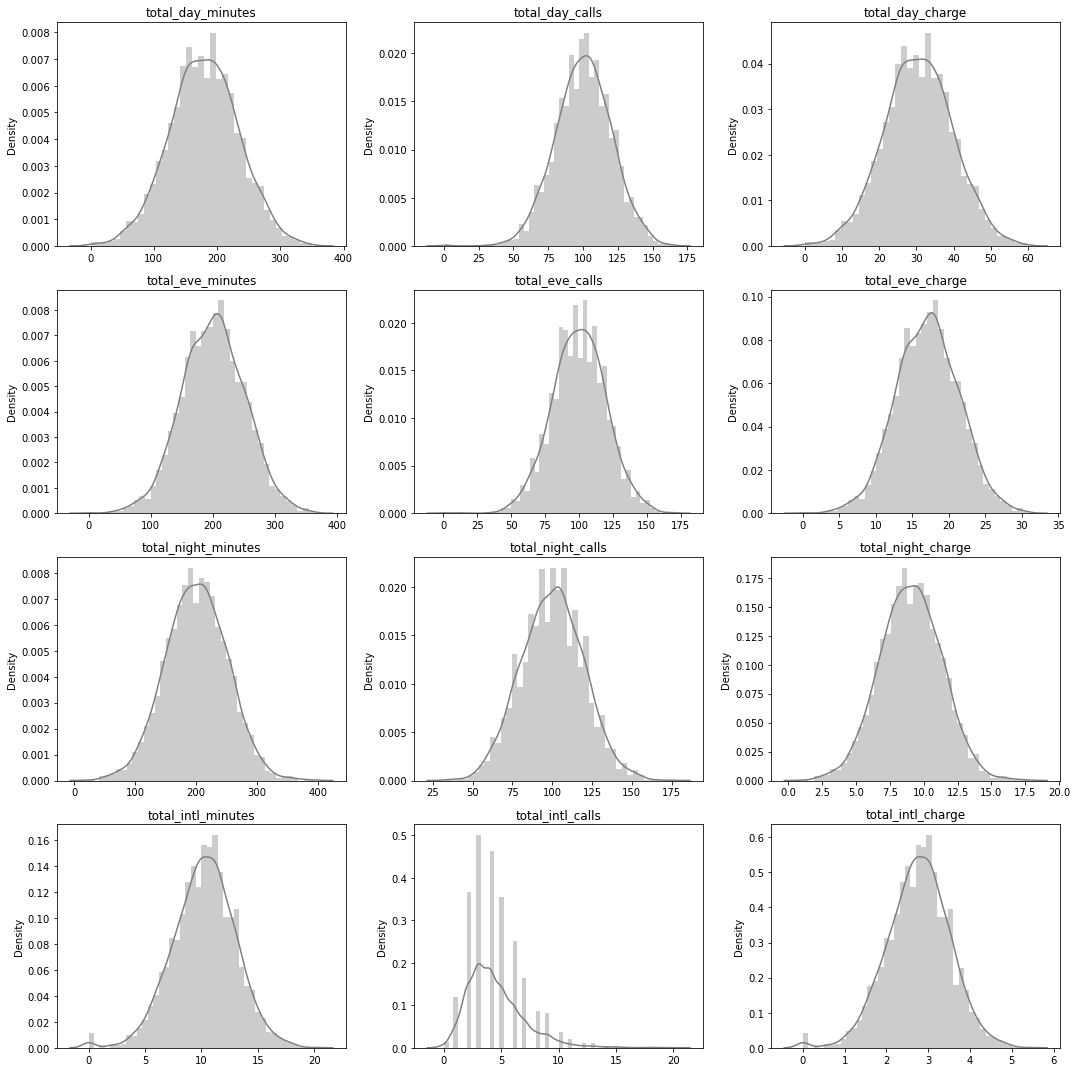

In [56]:
plt.figure(figsize = (15,15))

columns = ['total_day_minutes',
       'total_day_calls', 'total_day_charge', 'total_eve_minutes',
       'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
       'total_night_calls', 'total_night_charge', 'total_intl_minutes',
       'total_intl_calls', 'total_intl_charge']

for i,col in enumerate(columns):
    plt.subplot(4,3,i+1)
    sns.distplot(df_numeric[col], color='gray')
    plt.title(col)
    plt.xlabel('')

plt.tight_layout()
plt.show()

From the distribution plots above, we see that the call duration during the day, evening and night is concentrated around 200 minutes, while the average duration of an international call is around 10 minutes. The total number of calls is concentrated around 100 for calls made during the day, evening and night, while is arount 3 to 5 for international calls. Despite the similarities in distributions for day, evening and night, the total charge distribution has different ranges for these variables. This is clearly shown in the next bar charts.

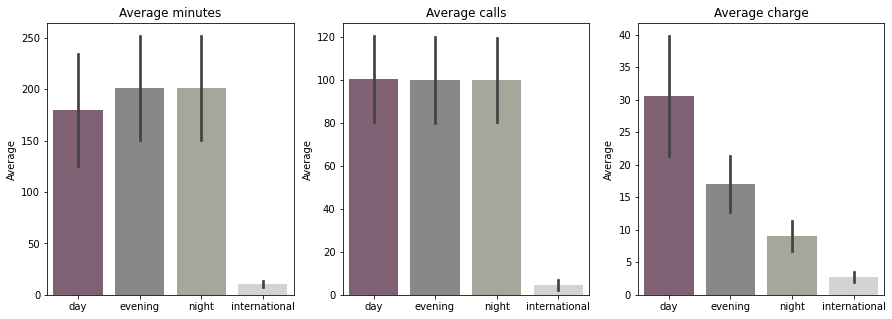

In [57]:
def compare_groups(columns, labels):
    plt.figure(figsize=(15,5))
    for i,col in enumerate(columns):
        plt.subplot(1,3,i+1)
        data = df_numeric[col[1]].melt()
        g = sns.barplot(x='variable',y='value',data=data, palette=['#855c75','#888888','#a5aa99','lightgray'], ci='sd')
        g.set_xticklabels(labels)
        plt.title(col[0])
        plt.xlabel('')
        plt.ylabel('Average')
    plt.show()
    
columns = [('Average minutes', ['total_day_minutes','total_eve_minutes','total_night_minutes','total_intl_minutes']),
          ('Average calls', ['total_day_calls','total_eve_calls','total_night_calls','total_intl_calls']),
          ('Average charge',['total_day_charge','total_eve_charge','total_night_charge','total_intl_charge'])]
labels = ['day','evening','night','international']
compare_groups(columns,labels)

There is no significant differences among day, evening and night average call duration and the average number of calls made are exactly the same. However a significant difference is found in the average charge, where the highest average charge is from the calls made during the day, indicating that there is a difference among call fares charged in each period of the day. This is exactly what the next bar chart shows.

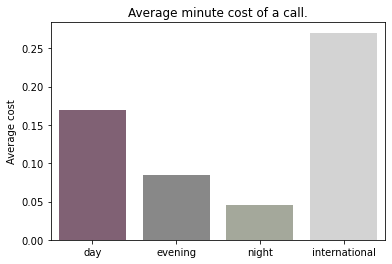

In [58]:
# Average minute cost of a call per period.

columns = [('cost_day_min',['total_day_minutes','total_day_charge']),('cost_eve_min',['total_eve_minutes','total_eve_charge']),
          ('cost_night_min',['total_night_minutes','total_night_charge']),
           ('cost_intl_min',['total_intl_minutes','total_intl_charge'])]

for cols in columns:
    df_numeric[cols[0]]=df_numeric[cols[1][1]]/df_numeric[cols[1][0]]

data = df_numeric[['cost_day_min','cost_eve_min','cost_night_min','cost_intl_min']].melt()

g = sns.barplot(x='variable',y='value',data=data, order=['cost_day_min','cost_eve_min','cost_night_min','cost_intl_min'],
                ci='sd', palette=['#855c75','#888888','#a5aa99','lightgray'])
g.set_xticklabels(['day','evening','night','international'])
plt.xlabel('')
plt.ylabel('Average cost')
plt.title('Average minute cost of a call.')
plt.show()

Indeed, the cost per minute of a call is more expensive during the day and cheaper during the evening and night. The international fare is the most expensive, which is a commom pattern. Now, let's evaluate the churn considering those variables.

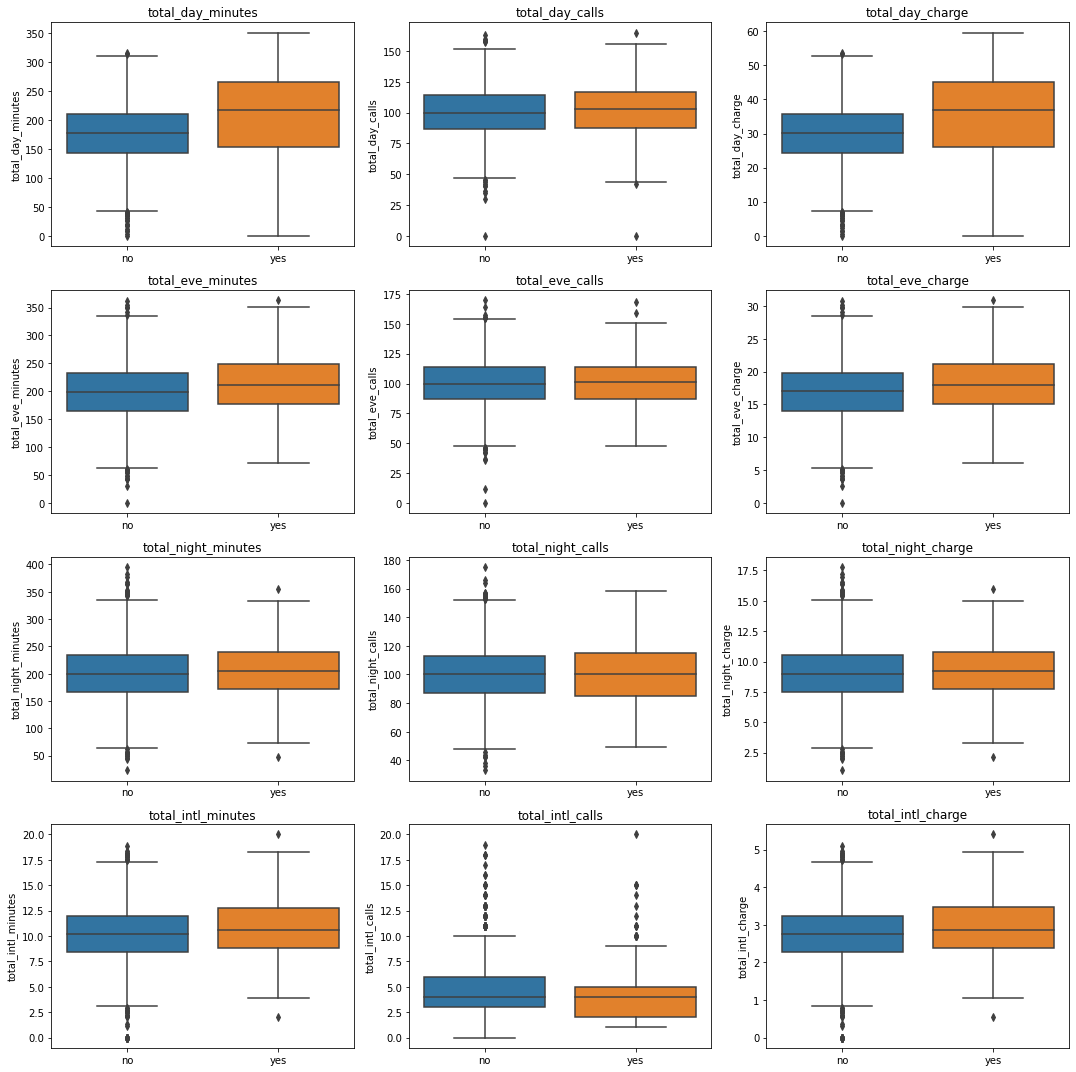

In [59]:
def boxplot(columns):
    plt.figure(figsize=(15,15))

    for i,col in enumerate(columns):
        plt.subplot(4,3,i+1)
        sns.boxplot(x = 'churn', y=col, data=df_numeric, palette=["#1F77B4", "#FF7F0E"])
        plt.title(col)
        plt.xlabel('')

    plt.tight_layout()
    plt.show()

columns = ['total_day_minutes',
       'total_day_calls', 'total_day_charge', 'total_eve_minutes',
       'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
       'total_night_calls', 'total_night_charge', 'total_intl_minutes',
       'total_intl_calls', 'total_intl_charge']

boxplot(columns)

Customers that churn make longer calls during the day and, as a result, the charges are higher. However, the number of calls doesn't seem to be different between the two groups. Thus, the average differences in charge arises from the average differences in call duration. The same pattern is observed for the calls during the evening and night, despite the differences being less pronounced.

Considering the international calls (total_intl_minutes, total_intl_calls, total_intl_charge), it seems to have a slightly difference in total minutes and total charge. However, as seen in the table below, there is no difference among the means of call duration, number of calls and total charge for customers that have an international plan, which, as saw earlier, have a higher odd ratio to churn.

In [60]:
df_train[['international_plan','total_intl_minutes','total_intl_calls', 'total_intl_charge']]\
    .groupby('international_plan').mean()

,total_intl_minutes,total_intl_calls,total_intl_charge
international_plan,,,
no,10.195349,4.465449,2.753279
yes,10.628173,4.609907,2.869907


#### 1.2.4 Are there differences in total charge for each churn category?

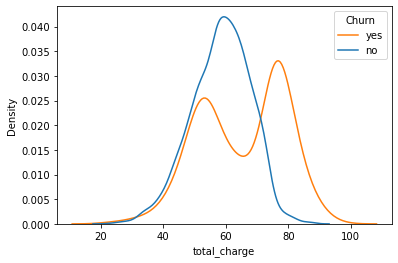

In [61]:
# Calculating the total charge adding the variables related with charge and the total_minutes adding variables related with
# minutes.
total_charge = df_numeric[['total_day_charge','total_eve_charge','total_night_charge','total_intl_charge']].sum(axis=1)\
                .to_frame().rename(columns={0:'total_charge'})
total_charge['churn'] = df_numeric['churn']
total_charge['total_minutes'] = df_numeric[['total_day_minutes','total_eve_minutes','total_night_minutes',
                                            'total_intl_minutes']].sum(axis=1)

# Plot: distribution of total charge for not churn and churn groups.
sns.distplot(total_charge[total_charge['churn']=='yes']['total_charge'], hist=False, color="#FF7F0E", label='yes')
sns.distplot(total_charge[total_charge['churn']=='no']['total_charge'], hist=False, color="#1F77B4", label='no')
plt.legend(title="Churn")
plt.show()

The total charge of g_churn follows a bimodal distribution and the second peak present higher total charge. This subgroup is important to the company, because they have the highest charges, but are leaving the company. A bimodal distribution occurs because of underlying behavior, let's see if we can find what this behavior might be.

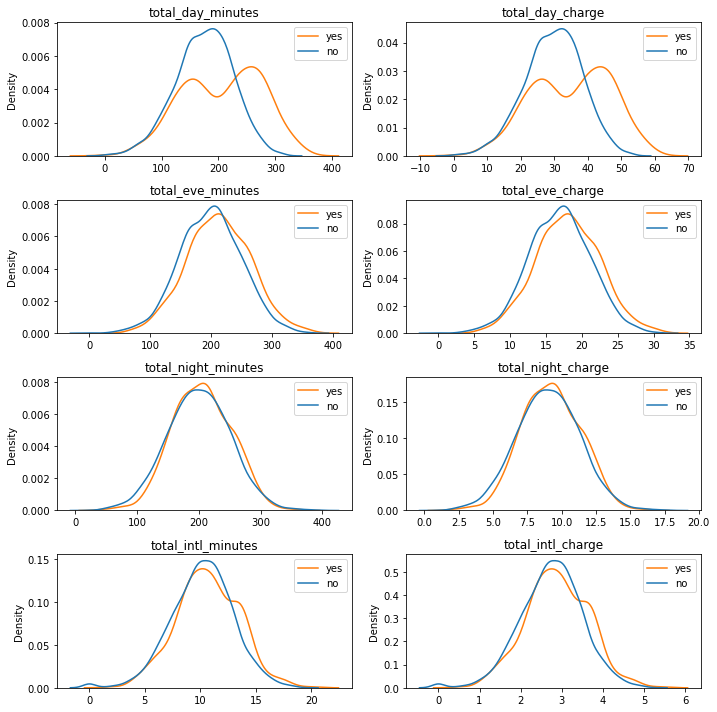

In [62]:
columns = ['total_day_minutes','total_day_charge', 'total_eve_minutes','total_eve_charge', 'total_night_minutes',
           'total_night_charge', 'total_intl_minutes','total_intl_charge']

plt.figure(figsize=(10,10))

for i,col in enumerate(columns):
    plt.subplot(4,2,i+1)
    sns.distplot(df_numeric[df_numeric['churn']=='yes'][col], hist=False, color="#FF7F0E", label='yes')
    sns.distplot(df_numeric[df_numeric['churn']=='no'][col], hist=False, color="#1F77B4", label='no')
    plt.title(col)
    plt.xlabel('')
    plt.legend()

plt.tight_layout()
plt.show()

The churn group has a bimodal distribution for total call duration during the day, indicating that there are two subgroups: one that make shorter calls and another that makes longer calls. The total charge for churn group also follows the same distribution, evidencing the relationship between these two variables. This pattern can also be seen in the distribution of evening, night and international calls in less pronounced way.

Once total_charge results from the sum of all individual charges, the bimodal pattern is maintained.

In this case, a better way to compare the the total charge of the groups is using the empirical cumulative distribution function.

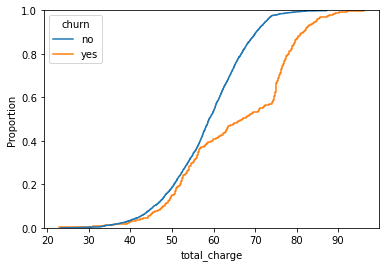

In [63]:
# Empirical cumulative distribution function

sns.ecdfplot(total_charge, x="total_charge", hue="churn", palette=["#1F77B4", "#FF7F0E"])
plt.show()

The distributions differ considerably after total_charge > 55 (approximate value). We can assure that this difference is statistical significant applying the Kolmogorov-Smirnov test, that evaluates if the distributions of the groups are from the same population.

In [64]:
# Kolmogorov-Smirnov test

# H0: samples are from the same distribution
# H1: samples are from different distributuions

stat, p_value = kstest(total_charge[total_charge['churn']=='yes']['total_charge'],
                      total_charge[total_charge['churn']=='no']['total_charge'])
if p_value <= 0.05:
    print('The distributions are different from each other. p_value: {:.2e}'.format(p_value))

The distributions are different from each other. p_value: 5.55e-16


#### 1.2.5 What is the revenue proportion lost due to churn?

In [65]:
revenue_lost = total_charge[total_charge['churn']=='yes']['total_charge'].sum()*100/total_charge['total_charge'].sum()
print('The proportion of the revenue lost is {}%'.format(np.round(revenue_lost)))

The proportion of the revenue lost is 16.0%


Average charge of peak 1:  53.42
Local minimum between the peaks:  65.66
Average charge of peak 2:  76.92


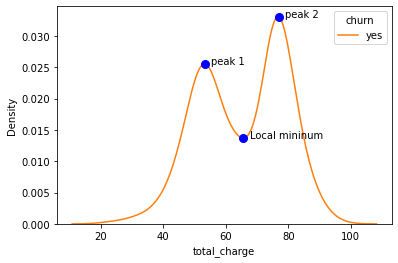

In [66]:
# Total charge at each of the peaks of churn group distribution
ax = sns.distplot(total_charge[total_charge['churn']=='yes']['total_charge'], hist=False, color="#FF7F0E", label='yes')
ax.legend(title='churn')

x = ax.lines[0].get_xdata() # Get the x data of the distribution
y = ax.lines[0].get_ydata() # Get the y data of the distribution

# Fist peak
maxid1 = np.argmax(y[np.where(x <60)])
print('Average charge of peak 1: ', np.round(x[maxid1],2))

# Valley between peaks
subset = y[np.where((x>55)&(x<70))]
minid_subset = np.argmin(subset)
y_min = subset[minid_subset]
minid = np.where(y==y_min)
print('Local minimum between the peaks: ', np.round(x[minid][0],2))

# Second peak
maxid2 = np.argmax(y)
print('Average charge of peak 2: ', np.round(x[maxid2],2))

plt.plot(x[maxid2],y[maxid2], 'bo', ms=8)
plt.annotate('peak 2', (x[maxid2]+2,y[maxid2]))
plt.plot(x[maxid1],y[maxid1], 'bo', ms=8)
plt.annotate('peak 1', (x[maxid1]+2,y[maxid1]))
plt.plot(x[minid],y[minid], 'bo', ms=8)
plt.annotate('Local mininum', (x[minid]+2,y[minid]))
plt.show()

In [67]:
# Now, we can determine the proportion of customers that churn and have total charge higher than 76.92.
total_charge_churn = total_charge[total_charge['churn']=='yes']
churn_high_charge = total_charge_churn[total_charge_churn['total_charge']>=x[maxid2]]['total_charge'].shape[0]*100/total_charge_churn.shape[0]

# Mean of total charge not churn group
not_churn_charge_mean = total_charge[total_charge['churn']=='no']['total_charge'].mean()

print('{}% of customers that churn spent at least ${}, while the average charge of not churn group is ${}.'\
      .format(np.round(churn_high_charge,2),np.round(x[maxid2],2),np.round(not_churn_charge_mean,2)))

23.81% of customers that churn spent at least $76.92, while the average charge of not churn group is $58.45.


## 2. Data Transformations

### 2.1 Feature Engineering

In [68]:
# The column state_name will also be removed because it has the same information as the state column.

df_train_transf = df_train.drop(columns=['state_name'])

In [69]:
# total_charge
features = [name for name in df_train.columns if re.search("charge", name)]
df_train_transf['total_charge'] = df_train_transf[features].sum(axis=1)

# total_minutes
features = [name for name in df_train.columns if re.search("minutes", name)]
df_train_transf['total_minutes'] = df_train_transf[features].sum(axis=1)

# total_calls
features = [name for name in df_train.columns if re.search("total.*calls", name)]
df_train_transf['total_calls'] = df_train_transf[features].sum(axis=1)

In [70]:
df_train_transf.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,...,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,region,total_charge,total_minutes,total_calls
0,KS,128,area_code_415,no,yes,25,265.1,110,45.07,197.4,...,11.01,10.0,3,2.70,1,no,Midwest,75.56,717.2,303
1,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,...,11.45,13.7,3,3.70,1,no,Midwest,59.24,625.2,332
2,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,...,7.32,12.2,5,3.29,0,no,Northeast,62.29,539.4,333
3,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,...,8.86,6.6,7,1.78,2,no,Midwest,66.80,564.8,255
4,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,...,8.41,10.1,3,2.73,3,no,South,52.09,512.0,359


### 2.2 Encoding categorical variables.

In [71]:
# Creating n-1 dummy variables. Since I will use logistic regression on this data, creating n-1 dummy variables is enough to
# represent all the information

df_train_transf = pd.get_dummies(df_train_transf,drop_first=True,
                                 columns=['state','area_code','region','international_plan','voice_mail_plan','churn'])

In [72]:
df_train_transf = df_train_transf.rename(columns={'churn_yes':'churn','voice_mail_plan_yes':'voice_mail_plan',
                                'international_plan_yes':'international_plan'})

In [73]:
df_train_transf.head()

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,...,state_WV,state_WY,area_code_area_code_415,area_code_area_code_510,region_Northeast,region_South,region_West,international_plan,voice_mail_plan,churn
0,128,25,265.1,110,45.07,197.4,99,16.78,244.7,91,...,0,0,1,0,0,0,0,0,1,0
1,107,26,161.6,123,27.47,195.5,103,16.62,254.4,103,...,0,0,1,0,0,0,0,0,1,0
2,137,0,243.4,114,41.38,121.2,110,10.30,162.6,104,...,0,0,1,0,1,0,0,0,0,0
3,84,0,299.4,71,50.90,61.9,88,5.26,196.9,89,...,0,0,0,0,0,0,0,1,0,0
4,75,0,166.7,113,28.34,148.3,122,12.61,186.9,121,...,0,0,1,0,0,1,0,1,0,0


### 2.3 Correlation Matrix for numerical features and churn

In [74]:
columns = df_train_transf.select_dtypes(include=['float64','int64']).columns.to_list()
columns.append('churn')

fig = px.imshow(df_train_transf[columns].corr(),color_continuous_scale='blues')
fig.update_xaxes(tickangle=45)
fig.show()

As expected, the pairs [total_day_minutes, total_day_charge], [total_even_minutes, total_even_charge], [total_night_minutes, total_night_charge], [total_intl_minutes,total_intl_charge] are perfectly correlated. Thus, since they represent the same information, these pairs have the same correlation coefficient with the target feature. Furthermore, it is observed that the correlation coefficient decreases from day, evening, international and night. This observation are in accordance with the patterns observed in topic 1.2.3. The highest correlation coefficient with churn was around 0.2 from the pair [total_day_minutes, total_day_charge] and number_of_customer_service calls.

The new features total_charge, total_minutes and total_calls presented higher correlation with churn than their individuals, showing that they might be better features to predict churn.

### 2.4 Scaling the data

In [75]:
features = df_train_transf.select_dtypes(include=['float64','int64']).columns

df_train_standard = df_train_transf.copy()

scaler = StandardScaler()
scaler.fit(df_train_standard[features])
df_train_standard[features] = scaler.transform(df_train_standard[features])
df_train_standard.head()

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,...,state_WV,state_WY,area_code_area_code_415,area_code_area_code_510,region_Northeast,region_South,region_West,international_plan,voice_mail_plan,churn
0,0.676489,1.234883,1.566767,0.476643,1.567036,-0.070610,-0.055940,-0.070427,0.866743,-0.465494,...,0,0,1,0,0,0,0,0,1,0
1,0.149065,1.307948,-0.333738,1.124503,-0.334013,-0.108080,0.144867,-0.107549,1.058571,0.147825,...,0,0,1,0,0,0,0,0,1,0
2,0.902529,-0.591760,1.168304,0.675985,1.168464,-1.573383,0.496279,-1.573900,-0.756869,0.198935,...,0,0,1,0,1,0,0,0,0,0
3,-0.428590,-0.591760,2.196596,-1.466936,2.196759,-2.742865,-0.608159,-2.743268,-0.078551,-0.567714,...,0,0,0,0,0,0,0,1,0,0
4,-0.654629,-0.591760,-0.240090,0.626149,-0.240041,-1.038932,1.098699,-1.037939,-0.276311,1.067803,...,0,0,1,0,0,1,0,1,0,0


### 2.5 Applying transformations to the test set

In [76]:
# Import test set
df_test = pd.read_csv('projeto4_telecom_teste.csv')
df_test.drop(columns = ['Unnamed: 0'], inplace = True)

In [77]:
df_test['churn'].value_counts()

no     1443
yes     224
Name: churn, dtype: int64

In [78]:
# Applying the transformations
df_test = df_test.merge(right=regionAbbr.drop(columns='State/District'),how='left',left_on='state',right_on='Postal Code')\
                .drop(columns='Postal Code')

# Feature Engineering
# total_charge
features = [name for name in df_test.columns if re.search("charge", name)]
df_test['total_charge'] = df_test[features].sum(axis=1)

# total_minutes
features = [name for name in df_test.columns if re.search("minutes", name)]
df_test['total_minutes'] = df_test[features].sum(axis=1)

# total_calls
features = [name for name in df_test.columns if re.search("total.*calls", name)]
df_test['total_calls'] = df_test[features].sum(axis=1)

# Dummy vars
df_test = pd.get_dummies(df_test,drop_first=True, columns=['state','area_code','region','international_plan',
                                                           'voice_mail_plan','churn'])

df_test = df_test.rename(columns={'churn_yes':'churn','voice_mail_plan_yes':'voice_mail_plan',
                                'international_plan_yes':'international_plan'})

In [79]:
df_test.head()

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,...,state_WV,state_WY,area_code_area_code_415,area_code_area_code_510,region_Northeast,region_South,region_West,international_plan,voice_mail_plan,churn
0,101,0,70.9,123,12.05,211.9,73,18.01,236.0,73,...,0,0,0,1,0,0,1,0,0,0
1,137,0,223.6,86,38.01,244.8,139,20.81,94.2,81,...,0,0,0,1,0,0,1,0,0,0
2,103,29,294.7,95,50.10,237.3,105,20.17,300.3,127,...,0,0,0,0,0,0,0,0,1,0
3,99,0,216.8,123,36.86,126.4,88,10.74,220.6,82,...,0,0,1,0,0,0,1,0,0,0
4,108,0,197.4,78,33.56,124.0,101,10.54,204.5,107,...,0,0,1,0,0,1,0,0,0,0


In [80]:
df_test['churn'].value_counts()

0    1443
1     224
Name: churn, dtype: int64

In [81]:
# Standardization

df_test_standard = df_test.copy()

features = df_test_standard.select_dtypes(include=['float64','int64']).columns
df_test_standard[features] = scaler.transform(df_test_standard[features])
df_test_standard.head()

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,...,state_WV,state_WY,area_code_area_code_415,area_code_area_code_510,region_Northeast,region_South,region_West,international_plan,voice_mail_plan,churn
0,-0.001628,-0.591760,-1.999204,1.124503,-1.999591,0.215351,-1.361185,0.214955,0.694692,-1.385473,...,0,0,0,1,0,0,1,0,0,0
1,0.902529,-0.591760,0.804729,-0.719406,0.804456,0.864187,1.952128,0.864604,-2.109550,-0.976594,...,0,0,0,1,0,0,1,0,0,0
2,0.048603,1.527146,2.110293,-0.270887,2.110347,0.716276,0.245270,0.716112,1.966291,1.374463,...,0,0,0,0,0,0,0,0,1,0
3,-0.051859,-0.591760,0.679865,1.124503,0.680240,-1.470832,-0.608159,-1.471812,0.390141,-0.925484,...,0,0,1,0,0,0,1,0,0,0
4,0.174180,-0.591760,0.323635,-1.118088,0.323793,-1.518163,0.044463,-1.518215,0.071747,0.352264,...,0,0,1,0,0,1,0,0,0,0


### 2.5 Train and test data

In [82]:
Xtrain = df_train_standard.drop(columns='churn')
ytrain = df_train_standard['churn']

Xtest = df_test_standard.drop(columns='churn')
ytest = df_test_standard['churn']

## 3. Model Evaluation

There are various metrics that can be used to evaluate classification problems. Accuracy, ROC AUC, PR AUC, F1 score is some of them and commonly used. However, there are some recommendations related to their usage.

**Accuracy** should not be used in imbalanced classification problems, because it is easy to get a high accuracy score by simply classifying all observations as the majority class. Furthermore, accuracy is calculated on the predicted classes, thus it depends on a threshold. Considering this, accuracy should be used when classes are balanced and both classes are important.

**F1-Score** combines precision and recall into one metric by calculating the harmonic mean between those two. F1-score also depends on a threshold, because precision and recall are calculated on the predicted classes (not prediction scores). Thus, getting the right threshold is essencial to maximizes this metric. It should be used when positive class is more important.

**ROC AUC** this metric shows how good at ranking predictions your model is. It tells you what is the probability that a randomly chosen positive instance is ranked higher than a randomly chosen negative instance. The more top-left your curve is the higher the area and hence higher ROC AUC score. Use it when classes are equally important and imbalance is not heavy.

**PR AUC** combines precision (PPV) and Recall (TPR) in a single visualization. For every threshold, you calculate PPV and TPR and plot it. The higher on y-axis your curve is the better your model performance. This metric can be think as the average of precision scores calculated for each recall threshold.

Precision -> informs the proportion of false positives.
Recall -> informs the proportion of false negatives.

Based on the description above, I will use F1-score to evaluate the models, but I will also calculate other metrics to have a more general view of the models.

### 3.1 Functions to evaluate the models

In [83]:
def evaluate_model(X_test, y_test, y_pred, model):
    
    labels = []
    metrics = []
    
    # Accuracy
    accuracy = model.score(X_test, y_test)
    metrics.append(accuracy)
    labels.append('accuracy')

    # Precision score
    from sklearn.metrics import precision_score
    precision = precision_score(y_test, y_pred)
    metrics.append(precision)
    labels.append('precision')
      
    # Recall score
    from sklearn.metrics import recall_score
    recall = recall_score(y_test, y_pred)
    metrics.append(recall)
    labels.append('recall')

    # F1-score
    from sklearn.metrics import f1_score
    f1score = f1_score(y_test, y_pred)
    metrics.append(f1score)
    labels.append('f1_score')

    # ROC-AUC
    from sklearn.metrics import roc_auc_score
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    metrics.append(roc_auc)
    labels.append('ROC-AUC')
    
    # PR-AUC | Average Precision
    from sklearn.metrics import average_precision_score
    average_precision = average_precision_score(y_test, model.predict_proba(X_test)[:,1])
    metrics.append(average_precision)
    labels.append('PR-AUC')
    
    return labels,metrics

In [84]:
def plot_metrics_train_test(Xtrain,ytrain,Xtest,ytest,model, title):

    # Train performance
    y_pred_train = model.predict(Xtrain)
    labels1_train, metrics1_train = evaluate_model(Xtrain, ytrain, y_pred_train, model)

    # Test performance
    y_pred_test = model.predict(Xtest)
    labels1_test, metrics1_test = evaluate_model(Xtest, ytest,y_pred_test, model)

    df1 = pd.DataFrame({'metric': labels1_train, 'value': metrics1_train, 'data':['train']*len(labels1_train)})
    df2 = pd.DataFrame({'metric': labels1_test, 'value': metrics1_test, 'data':['test']*len(labels1_test)})
    graph = pd.concat([df1,df2,],ignore_index=True).sort_values(by='value')
    graph= graph.round(decimals=3)

    fig = px.bar(graph, x="value", y="metric", title=title, color = 'data',
             color_discrete_sequence=['#990099','gray'], labels=dict(value=" ",metric=" "), barmode='group',
            text='value')

    fig.update_xaxes(showticklabels=False)

    fig.show()

In [85]:
def slopegraph(Xtest, ytest, models, features, title, metrics):
    graph = {}
    # Calculating perfomance
    for feature, model in zip(features, models):
        y_pred_test = model.predict(Xtest[feature])
        labels, values = evaluate_model(Xtest[feature], ytest,y_pred_test, model)
        graph.setdefault('metric',[]).append(labels)
        graph.setdefault('value',[]).append(values)
        
    # Adding new key, value to graph
    for i in range(len(models)):
        vector = np.repeat(np.array('model'+str(i+1)),len(labels))
        graph.setdefault('model',[]).append(vector)
    
    # Unnesting lists from graph dictionary
    for k,v in graph.items():
        graph[k] = [value for lista in graph[k] for value in lista]
    
    # Creating Dataframe
    df = pd.DataFrame(graph)
    # Adding x axis to be used in the plot
    df['x'] = np.repeat(np.arange(1,len(models)+1), len(df['metric'].unique()))
    
    # Loop for slopegraph
    if metrics == None:
        metrics = list(df['metric'].unique())

    fig, ax = plt.subplots(1, figsize=(10,8))
    colors = ['gray','#EF553B','gray']
    for i,color in zip(metrics,colors):
        temp = df[df['metric'] == i]
        plt.plot(temp.x, temp.value,marker='o', lw=2.5, markersize=8, color=color)
        # print the metric value
        # first x point
        plt.text(temp.x.values[0]+0.15, temp.value.values[0], np.round(temp.value.values[0],3), ha='right', size=12)
        # other x point
        for row in range(1,temp.shape[0]):
            plt.text(temp.x.values[row]+0.15, temp.value.values[row], np.round(temp.value.values[row],3),
                     ha='right',size=12)

    # grid
    ax.xaxis.grid(color='gray', linestyle='solid', which='both', alpha=0.9)
    
    # x limits
    xlim = df['x'].unique().min(), df['x'].unique().max()
    
    # remove spines
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_bounds(xlim[0],xlim[1])
    ax.spines['bottom'].set_color('gray')
    ax.spines['top'].set_visible(False)

    # xaxis
    plt.xlim(xlim[0]-0.2,xlim[1]+0.5)
    plt.xticks(list(df['x'].unique()), labels=list(df['model'].unique()), fontsize=14)
    # yaxis
    yvalue = df[(df['model']=='model1') & (df['metric'].isin(metrics))]
    plt.yticks(list(yvalue['value']), labels= list(yvalue['metric']), fontsize=14)
    # title
    plt.title(title, loc='left', fontsize = 16)

    plt.show()

In [86]:
def best_threshold(Xtest, ytest, model):
    """Returns a dataframe with precision, recall, f1_score and the threshold."""

    from sklearn.metrics import precision_recall_curve
    pred = model.predict_proba(Xtest)
    precision, recall, threshold = precision_recall_curve(ytest, pred[:,1])
    fscore = 2*(precision * recall)/(precision + recall)
    df = pd.DataFrame({'threshold':threshold, 'precision': precision[:-1], 'recall':recall[:-1], 'fscore':fscore[:-1]})
    df.dropna(inplace=True)
    best_threshold = df[df['fscore']==df['fscore'].max()]['threshold'].values[0]
    
    # Obtaining accuracy for the best threshold
    ypred = model.predict_proba(Xtest)
    accuracy = np.mean(ytest == (ypred[:,1] >= best_threshold))
    
    df['accuracy'] = accuracy
    
    return df,best_threshold

In [87]:
def cross_val_train(model, x_train, y_train, features, metric, folds, results):
    result_cv = cross_val_score(model, x_train[features], y_train, scoring=metric, 
                         cv=StratifiedKFold(folds), n_jobs=-1)
    if results.empty:
        results['model1'] = result_cv
    else:
        results['model'+str(results.shape[1]+1)] = result_cv
    
    results.boxplot(grid=False)
    plt.ylabel('f1_score')
    plt.show()
    
    return results

## 4. Modeling

As shown during exploratory data analysis, not all features are important to predict churn and there are some features that are correlated, bringing the problem of multicollinearity into the mix. I will use two different approachs to deal with multicollinearity and irrelevant features:
1. Regularization (ridge and lasso)
2. Recursive feature elimination followed by regularization.

Regularization decreases the importance of irrelevant features to the model by decreasing their coefficients, or even turning them to zero, in case of lasso regularization. Recursive feature selection is a method of feature selection.

### 4.1 Model 1 - Base logistic regression

Since the classes are imbalanced, I will use the class_weight hyperparameter to balance them.

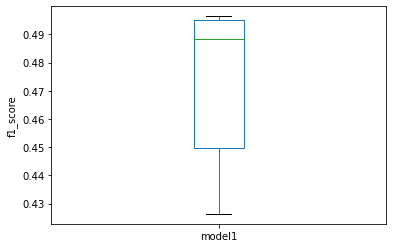

In [88]:
feature_m1 = Xtrain.columns
model = LogisticRegression(class_weight='balanced')

# Dataframe to save the cv_results
results = pd.DataFrame()

results = cross_val_train(model, Xtrain, ytrain, feature_m1, 'f1', 5, results)

In [89]:
model1 = LogisticRegression(class_weight='balanced').fit(Xtrain[feature_m1],ytrain)
y_pred = model1.predict(Xtest[feature_m1])

title = 'Model1 performance in train and test'

plot_metrics_train_test(Xtrain[feature_m1],ytrain,Xtest[feature_m1],ytest,model1, title)

The performance of the model in test is comparable with the performance in train, indicating that the model does not seem to be overfitted. 

Because recall is higher than precision, the proportion of false negatives is lower than the proportion of false positives. In other words, the model recover more true positives, but also labeled more false positives. The accuracy of this model is around 0.77, meaning that 77% of the responses are correct, while only 33% of the positive instances returned by the model are correctly labeled as positive.

### Model2 - Logistic Regression + Regularization (ridge)

Here, I will test the impact of class balancing and regularization. The default penalty apply in logistic regression is l2 (ridge regularization).

In [90]:
# Find the best C value

feature_m2 = Xtrain.columns

# Parameter to tune
tuned_param = {'C': [0.001,0.005,0.01,0.05,0.1,0.3,1], 'class_weight':[None, 'balanced']}

# Grid Search
grid_search = GridSearchCV(estimator = LogisticRegression(), 
                     param_grid = tuned_param, 
                     scoring = 'f1', return_train_score = True,     
                     cv = StratifiedKFold(5), n_jobs= -1).fit(Xtrain[feature_m2], ytrain)

In [91]:
# Best estimator
grid_search.best_estimator_

LogisticRegression(C=0.1, class_weight='balanced')

In [92]:
# Cross validation score
grid_search.best_score_

0.48362256844144913

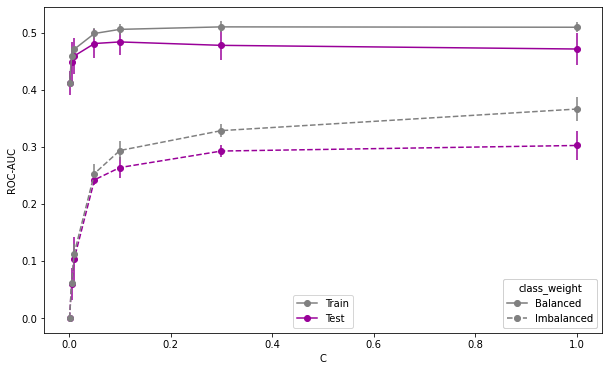

In [93]:
# Grid search results
search_reslt = pd.DataFrame(grid_search.cv_results_)[['param_C','param_class_weight','mean_test_score','std_test_score','mean_train_score','std_train_score']]

# Change None value in param_class_weight
search_reslt['param_class_weight'].iloc[range(0,13,2)] = 'imbalanced'

# Plot
fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlabel('C')
ax.set_ylabel('ROC-AUC')
ax.errorbar('param_C', 'mean_test_score', yerr = 'std_test_score',  marker = 'o', label = 'Test', color='#990099', 
            data = search_reslt[search_reslt['param_class_weight']=='balanced'])
ax.errorbar('param_C', 'mean_train_score', yerr = 'std_train_score',  marker = 'o', label = 'Train', color='gray',
            data = search_reslt[search_reslt['param_class_weight']=='balanced'])
ax.errorbar('param_C', 'mean_test_score', yerr = 'std_test_score',  marker = 'o', color='#990099',
            linestyle='--', data = search_reslt[search_reslt['param_class_weight']=='imbalanced'])
ax.errorbar('param_C', 'mean_train_score', yerr = 'std_train_score',  marker = 'o', color='gray',
            linestyle='--' ,data = search_reslt[search_reslt['param_class_weight']=='imbalanced'])

lines = plt.gca().get_lines()
include = [1,0]
legend1 = plt.legend([lines[i] for i in include],['Train','Test'],loc='lower center')
legend2 = plt.legend([lines[i] for i in [1,3]],['Balanced','Imbalanced'], title='class_weight')

plt.gca().add_artist(legend1)
plt.gca().add_artist(legend2)
plt.show()


Balancing the training data through class_weight hyperparameter improves considerably the performance of the model in train and test. C = 0.1 results in the best score.

Let's compare the cv_results of training of model1 and model2.

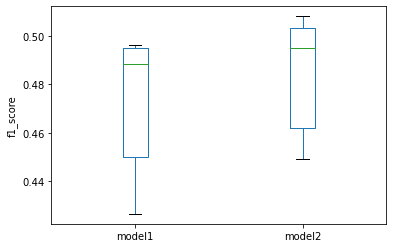

In [94]:
model2 = grid_search.best_estimator_

results = cross_val_train(model2, Xtrain, ytrain, feature_m2, 'f1', 5, results)

In [95]:
title = 'Model2 performance in train and test'

plot_metrics_train_test(Xtrain[feature_m2],ytrain,Xtest[feature_m2],ytest,model2, title)

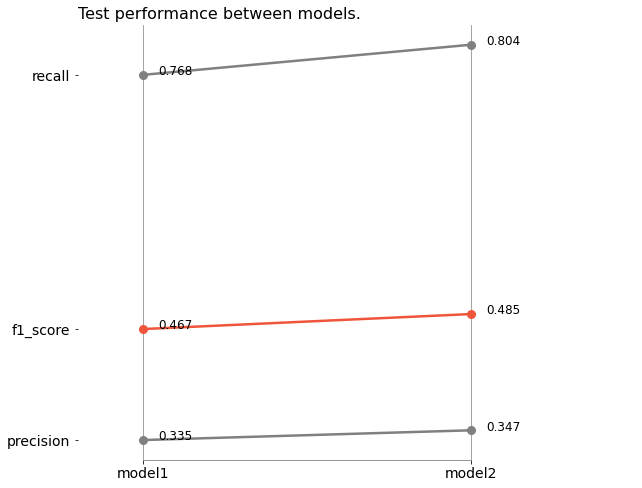

In [96]:
# Comparing the models 

models = [model1,model2]
features = [feature_m1, feature_m2]
metric = ['recall','f1_score','precision']
title = 'Test performance between models.'

df=slopegraph(Xtest, ytest, models, features, title, metric)

A slightly improvement was obtained using ridge regularization (l2). Let's see if lasso regularization (l1) can make it better.

### Model3 - Solvers liblinear and saga with l1 or l2 regularization

Now, I'm going to change the solver to evaluate the impact of lasso penalty (l1) in the model, because the default solver lbfgs only supports ridge regularization (l2). 

In [97]:
# Find the best solver

feature_m3 = Xtrain.columns

# Parameter to tune
tuned_param = {'C': [0.001,0.005,0.01,0.05,0.1,0.3,1], 'solver': ['liblinear','saga'], 'penalty':['l2','l1']}

# Grid Search
grid_search = GridSearchCV(estimator = LogisticRegression(class_weight='balanced'), 
                     param_grid = tuned_param, 
                     scoring = 'f1', return_train_score = True,     
                     cv = StratifiedKFold(5), n_jobs= -1).fit(Xtrain[feature_m3], ytrain)

In [98]:
model3 = grid_search.best_estimator_
model3

LogisticRegression(C=0.3, class_weight='balanced', penalty='l1', solver='saga')

In [99]:
grid_search.best_score_

0.49035110209441796

Let's compare the training cv_results for the models.

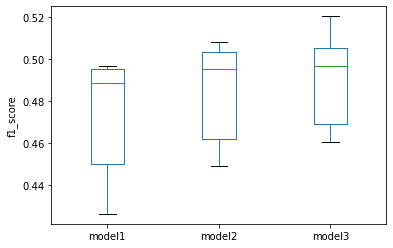

In [100]:
results = cross_val_train(model3, Xtrain, ytrain, feature_m3, 'f1', 5, results)

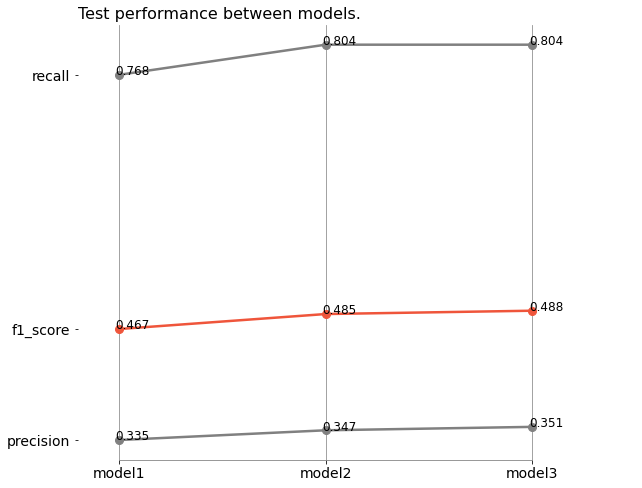

In [101]:
# Comparing the models
# Model3 behavies similar to model2

models = [model1,model2,model3]
features = [feature_m1, feature_m2, feature_m3]
metrics = ['recall','f1_score','precision']
title = 'Test performance between models.'

slopegraph(Xtest, ytest, models, features,title, metrics)

### Model4 - Feature selection with Recursive Feature Elimination with cross-validation.

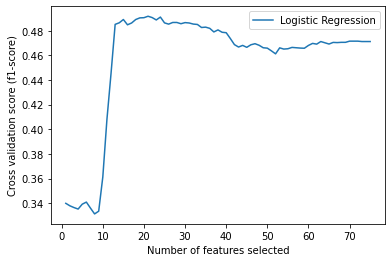

In [102]:
# Model
model = LogisticRegression(class_weight= 'balanced')

# RFECV search
# mininum number of features to consider
min_features_to_select = 1  
rfecv = RFECV(estimator = model, step=1, cv=StratifiedKFold(5),
              scoring='f1',
              min_features_to_select=min_features_to_select)
rfecv.fit(Xtrain[feature_m3], ytrain)

# Plot the performance x number of features selected
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (f1-score)")
plt.plot(range(min_features_to_select,
               len(rfecv.grid_scores_) + min_features_to_select),
         rfecv.grid_scores_, label = 'Logistic Regression')
plt.legend()
plt.show()

In [103]:
print('Logistic Regression - Best number of features: {}'.format(rfecv.n_features_))
rfe_features = Xtrain.columns[rfecv.ranking_ == 1]
rfe_features

Logistic Regression - Best number of features: 21


Index(['number_vmail_messages', 'number_customer_service_calls',
       'total_charge', 'state_AL', 'state_AZ', 'state_CA', 'state_HI',
       'state_IA', 'state_IL', 'state_MO', 'state_MS', 'state_MT', 'state_NJ',
       'state_RI', 'state_SC', 'state_TN', 'state_TX', 'state_VA', 'state_VT',
       'international_plan', 'voice_mail_plan'],
      dtype='object')

It is interesting that the states selected as important features are among the top 10 states with higher churn rate and the top 10 states with lower churn rate. The table below summarizes this observation.Furthermore, it is not a surprise that number_vmail_messages, number_customer_service_calls, international_plan, voice_mail_plan were chosen as important to predict churn, since their influence in churn was statistically significant. 

In [104]:
churn_rate_state = churn_state[churn_state['churn']=='yes'][['state','%']]\
                    .sort_values(by='%',ascending=False).rename(columns={'%':'churn_rate %'})
churn
churn_rate_state['churn_rank'] = range(1,churn_rate_state.shape[0]+1)
churn_rate_state['state']=['state_'+name for name in churn_rate_state['state']]
churn_rate_state[churn_rate_state['state'].isin([feature for feature in rfe_features if re.search('state',feature)])].reset_index(drop=True)

,state,churn_rate %,churn_rank
0,state_NJ,26.470588,1
1,state_CA,26.470588,2
2,state_TX,25.000000,3
3,state_SC,23.333333,5
4,state_MS,21.538462,7
5,state_MT,20.588235,11
6,state_MO,11.111111,34
7,state_VT,10.958904,35
8,state_AL,10.000000,36
9,state_TN,9.433962,40


#### Training a model with rfe_features

In [105]:
feature_m4 = rfe_features

model4 = LogisticRegression(class_weight= 'balanced').fit(Xtrain[feature_m4],ytrain)

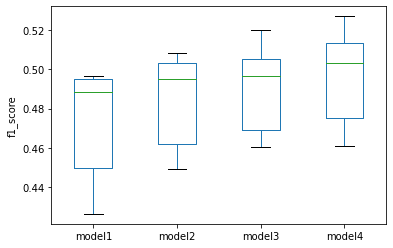

In [106]:
results = cross_val_train(model4, Xtrain, ytrain, feature_m4, 'f1', 5, results)

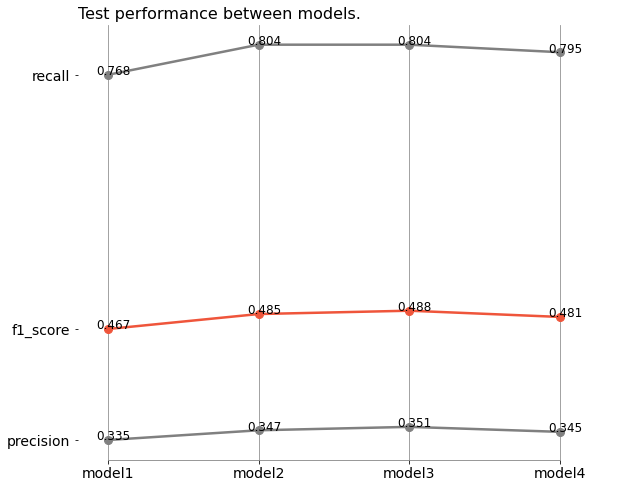

In [107]:
models = [model1,model2,model3, model4]
metrics = ['recall','f1_score','precision']
title = 'Test performance between models.'
features= [feature_m1,feature_m2,feature_m3,feature_m4]

slopegraph(Xtest, ytest, models, features,title, metrics)

Using only 21 features, pointed as the most important by RFE method, we obtained a model as good as model2 and model3, which were trained using all 75 features, and better than the base model1.

### Model5 - Applying regularization to model4

In [108]:
feature_m5 = rfe_features

tuned_param = {'C': [0.001,0.005,0.01,0.05,0.1,0.3,1]}

# Grid Search
grid_search = GridSearchCV(estimator = LogisticRegression(class_weight='balanced'), 
                     param_grid = tuned_param, 
                     scoring = 'f1', return_train_score = True,     
                     cv = StratifiedKFold(5), n_jobs= -1).fit(Xtrain[feature_m5], ytrain)

In [109]:
model5 = grid_search.best_estimator_
model5

LogisticRegression(C=0.1, class_weight='balanced')

In [110]:
grid_search.best_score_

0.49839833170542713

In [111]:
title = 'Model5 performance in train and test'

plot_metrics_train_test(Xtrain[feature_m5],ytrain,Xtest[feature_m5],ytest,model5, title)

Comparing the training cv_results with other models.

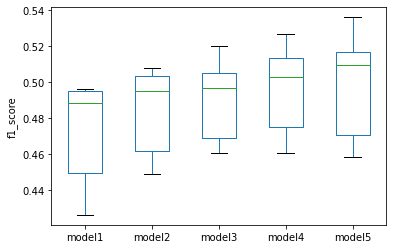

In [112]:
results = cross_val_train(model5, Xtrain, ytrain, feature_m5, 'f1', 5, results)

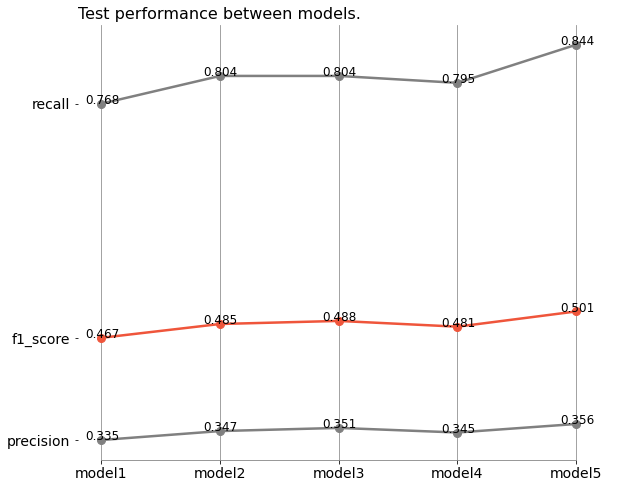

In [113]:
models = [model1,model2,model3, model4, model5]
metrics = ['recall','f1_score','precision']
title = 'Test performance between models.'
features= [feature_m1,feature_m2,feature_m3,feature_m4,feature_m5]

slopegraph(Xtest, ytest, models, features,title, metrics)

In [114]:
# Find the best threshold for model5
df_fscore, threshold = best_threshold(Xtest[feature_m5], ytest, model5)

df_fscore[df_fscore['threshold']==threshold]

,threshold,precision,recall,fscore,accuracy
1176,0.554253,0.382022,0.758929,0.508221,0.802639


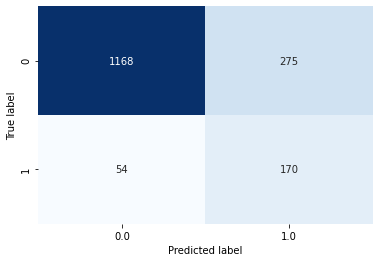

In [115]:
# Confusion Matrix
ypred = model5.predict_proba(Xtest[feature_m5])[:,1]

data = {'Reference':ytest, 'Prediction': np.round(ypred >= threshold)}
df = pd.DataFrame(data)
confusion_matrix = pd.crosstab(df['Reference'], df['Prediction'], rownames=['True label'], colnames=['Predicted label'])
sns.heatmap(confusion_matrix, cmap = 'Blues', annot=True, fmt='g', cbar=False)
plt.show()

## 5. Error Analysis

In [116]:
# Error analysis
error_anl = df_test[feature_m5].copy()
error_anl['churn']=df_test['churn']
error_anl['pred_prob'] = ypred
error_anl['pred'] = np.round(ypred >= threshold)

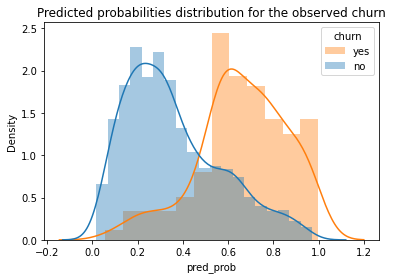

In [117]:
# Predicted probabilities distribution x observed churn
sns.distplot(error_anl[error_anl['churn']==1]['pred_prob'],hist=True, label='yes', color="#FF7F0E")
sns.distplot(error_anl[error_anl['churn']==0]['pred_prob'],hist=True, label='no',color='#1F77B4')
plt.legend(title='churn')
plt.title('Predicted probabilities distribution for the observed churn')
plt.show()

It is noticed a large overlap between predicted probabilities of each churn class. The model estimated a high probability for some examples that did not churn, this explains the higher amount of false positives. This overlap must be reduced in order to improve the prediction power of the model.  Let's start understanding how the model makes its decisions using SHAP.

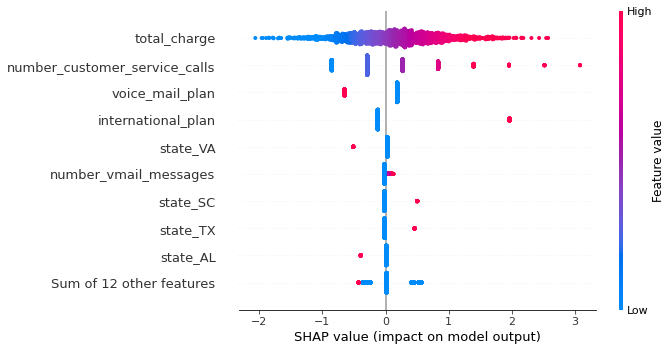

In [118]:
explainer = shap.Explainer(model5, Xtrain[feature_m5], feature_names=Xtrain[feature_m5].columns)
shap_values = explainer(Xtest[feature_m5])

shap.plots.beeswarm(shap_values)

Shap clearly shows that total_charge is the most important feature for the model, followed by number_customer_service_calls, voice_mail_plan and international_plan. This is a very nice summary of the insights obtained during exploratory data analysis.

1. The larger the total_charge value, the higher the probability to churn. This is totally in accordance with the patterns seen in the EDA that 23% of the churn group has an average total_charge higher than not churn group. 

2. The higher the number of service calls, the higher the probability to churn.

3. If the customer does not have a voice mail plan, the probability to churn increases. So, voice_mail_plan = 1 have a high impact in predicting the not churn group.

4. International plan has a great impact in predicting churn.

Now, I going to divide the predicted probabilities into bins to evaluate which bin most contributed to the prediction errors.

In [119]:
# Select the errors
error_instances = error_anl[error_anl['churn'] != error_anl['pred']]

# Create bins 
error_instances['groups'] = pd.cut(error_instances['pred_prob'],bins=10, right=False, 
                                   labels=['0-10%','10-20%','20-30%','30-40%','40-50%',
                                           '50-60%','60-70%','70-80%','80-90%','90-100%'])

# Count values in each bin
error_instances.groupby('groups').size()

groups
0-10%        3
10-20%       6
20-30%       8
30-40%       7
40-50%      15
50-60%      71
60-70%     101
70-80%      50
80-90%      43
90-100%     25
dtype: int64

In [120]:
error_instances[error_instances['groups']=='50-60%']['pred'].value_counts()

1.0    56
0.0    15
Name: pred, dtype: int64

Because the best threshold for model5 is 0.55, all predictions in error_instances dataframe that are in the groups with probability lower than 0.55 were misclassified as 0, and everything above the threshold was misclassified as 1. There are much more false positive errors, as expected.

SHAP library allows us to verify the impact of the features in the prediction of each instance. Let's do this for the group 60-70%. 

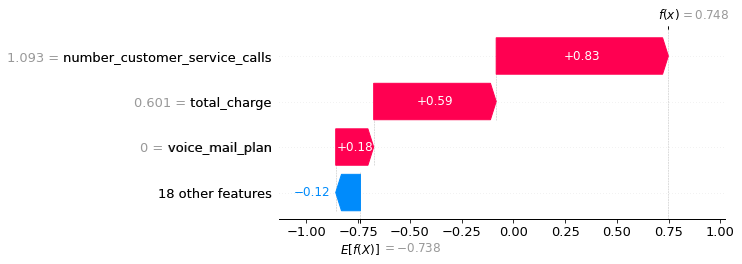

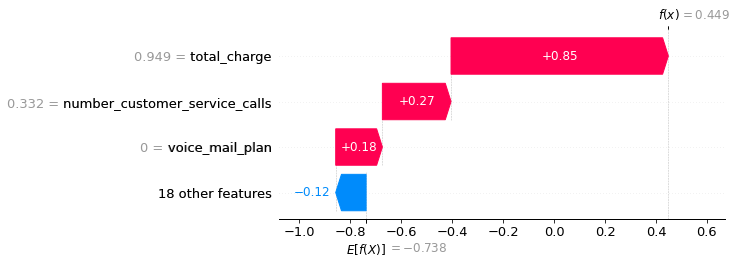

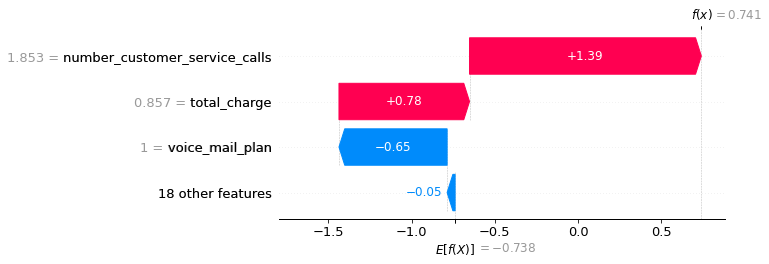

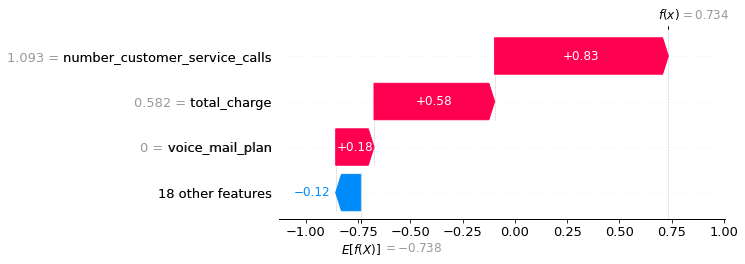

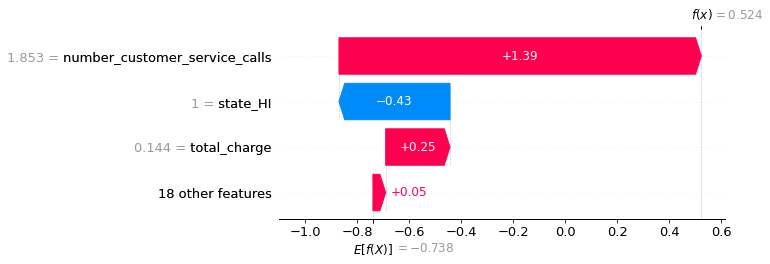

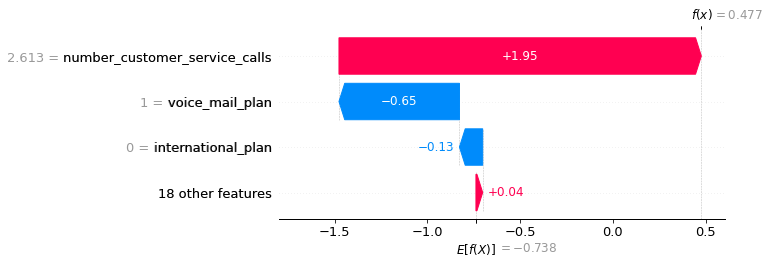

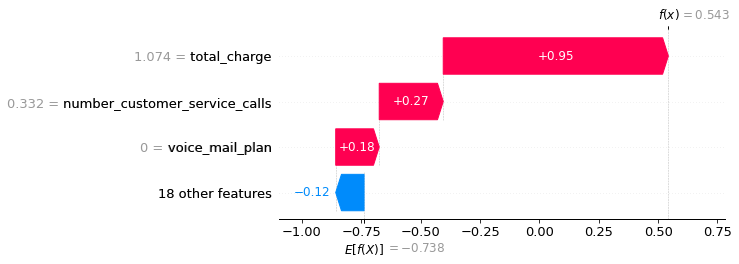

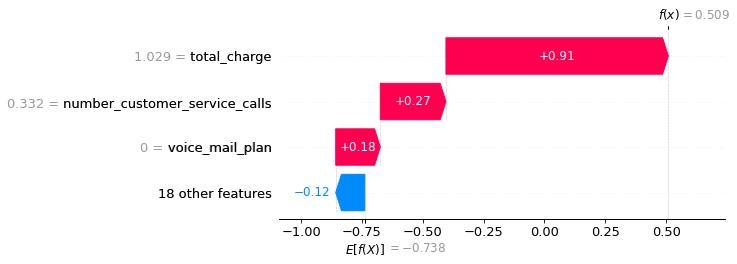

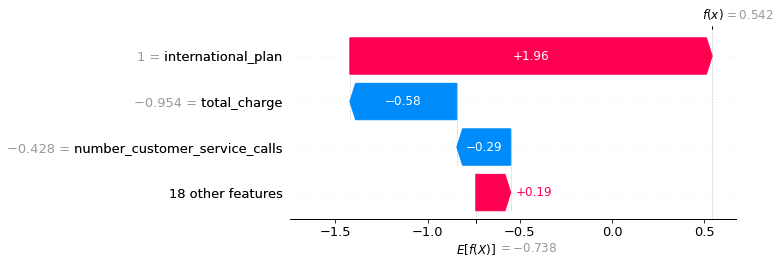

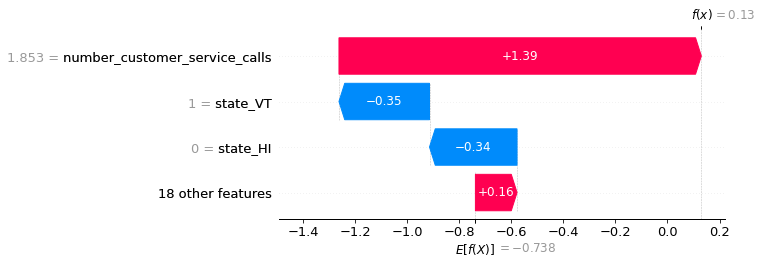

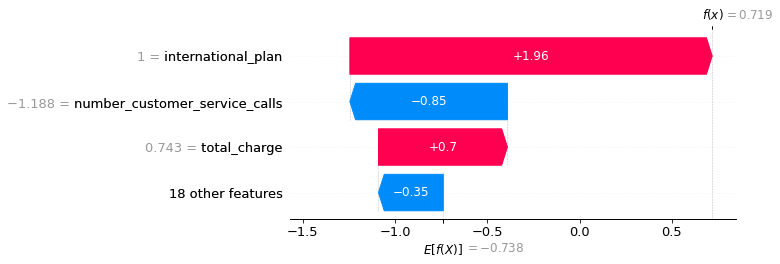

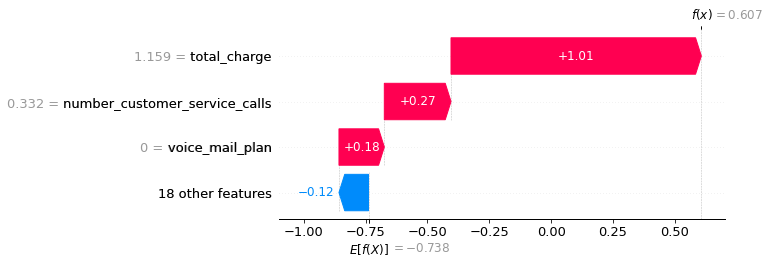

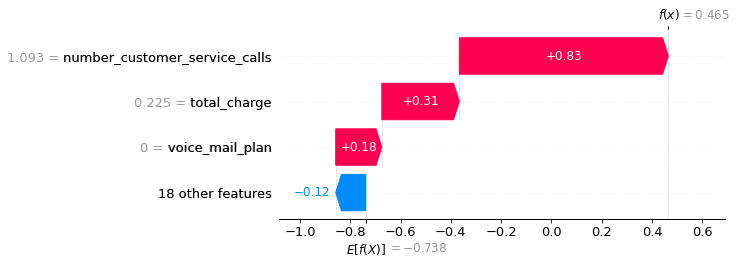

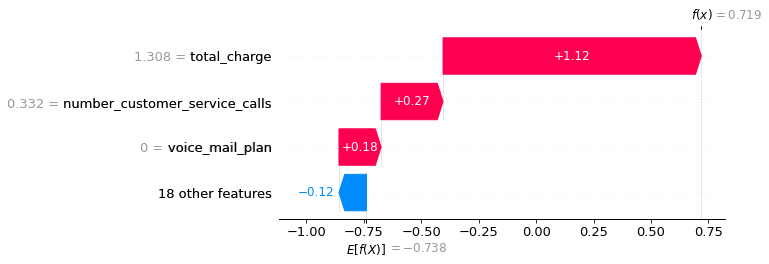

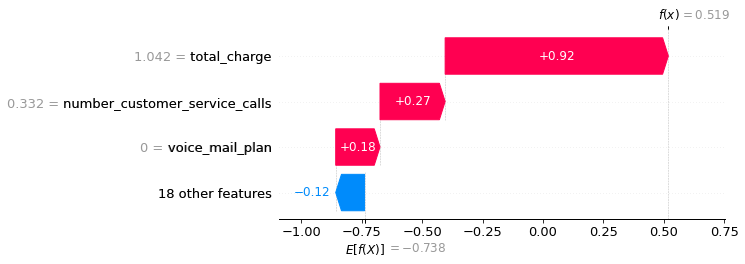

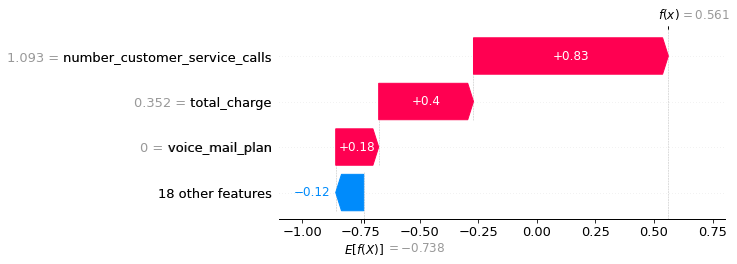

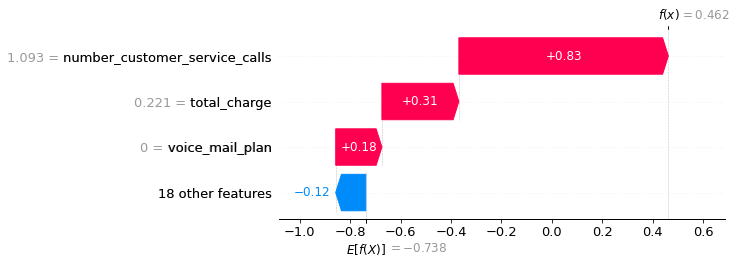

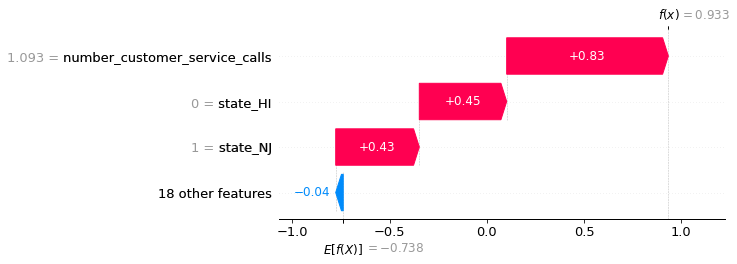

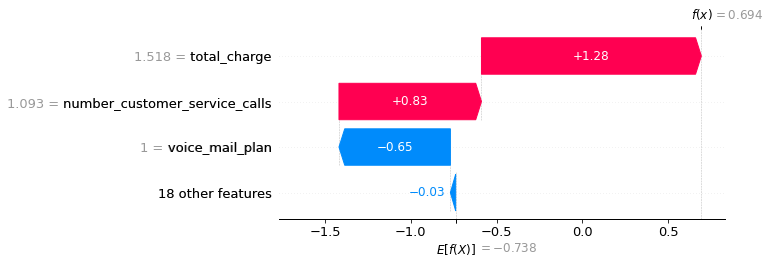

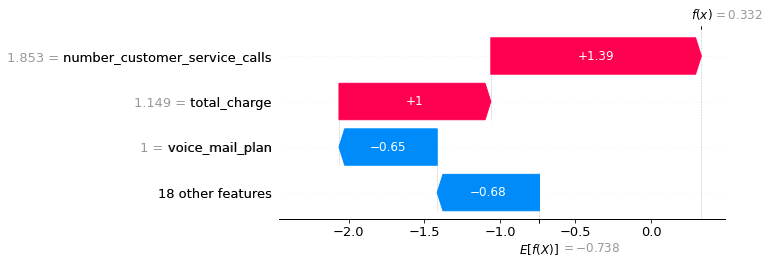

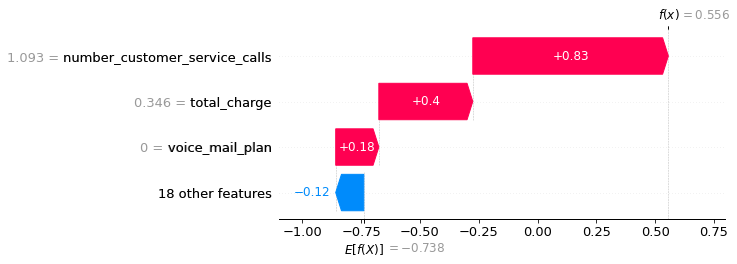

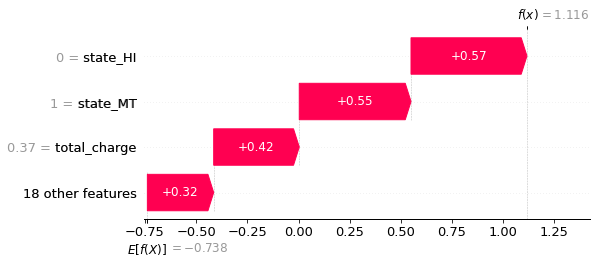

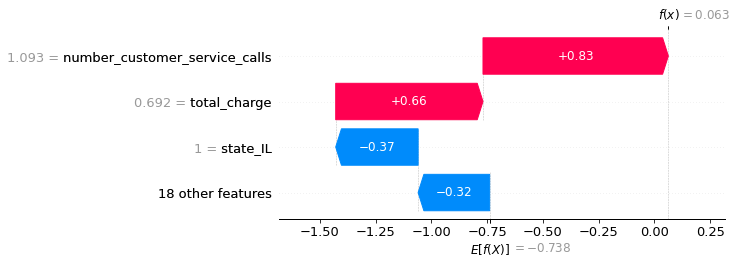

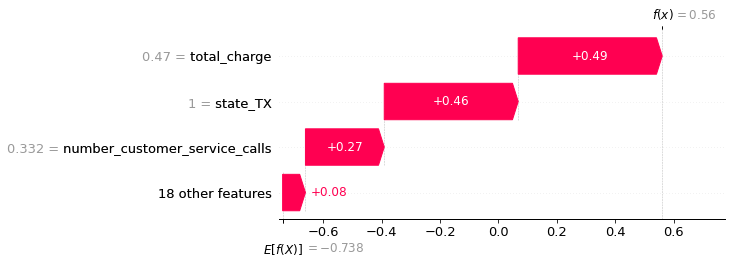

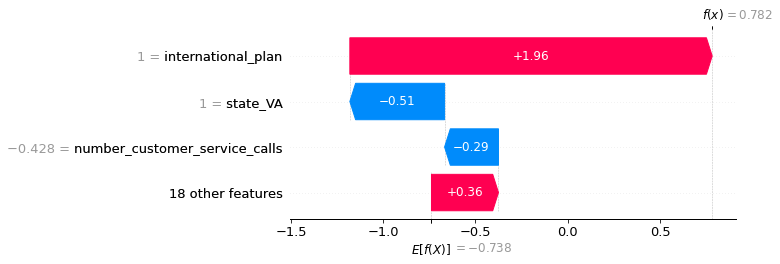

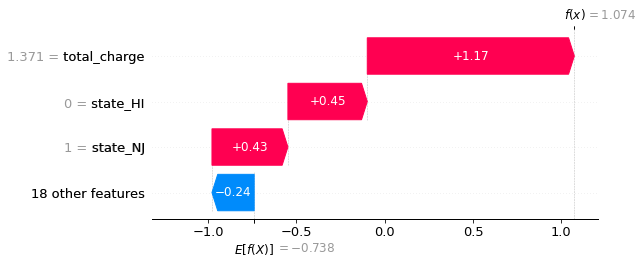

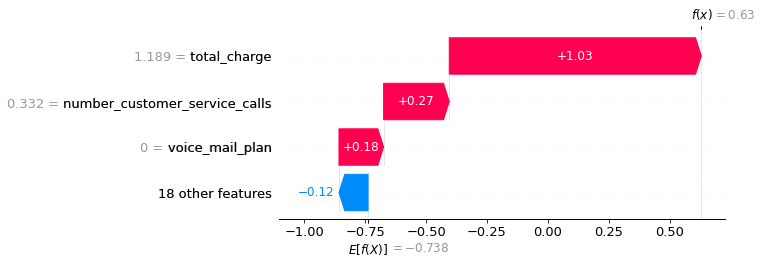

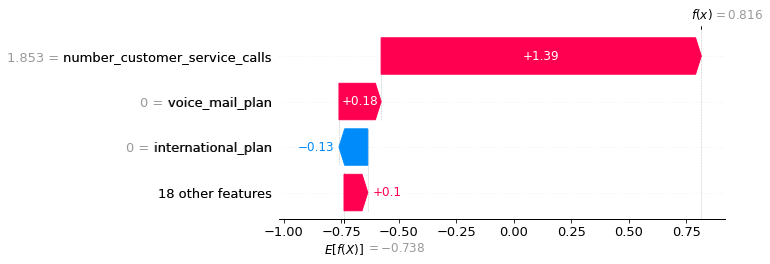

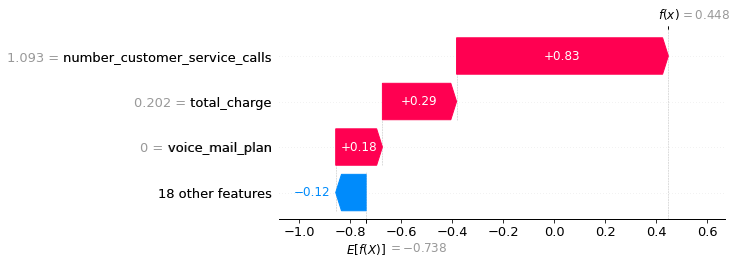

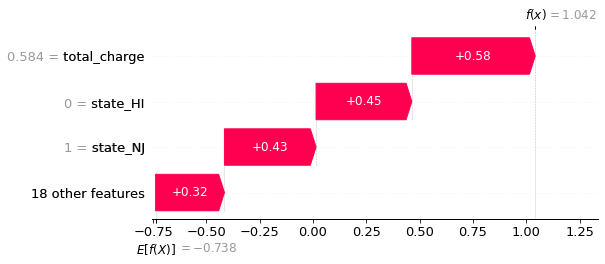

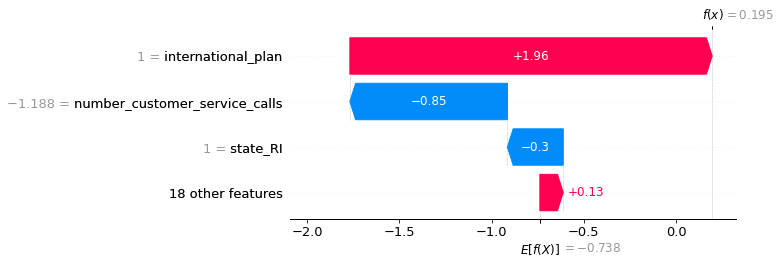

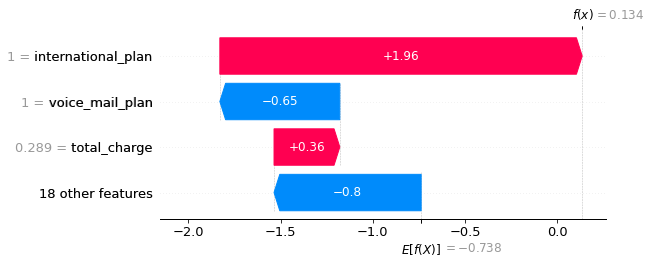

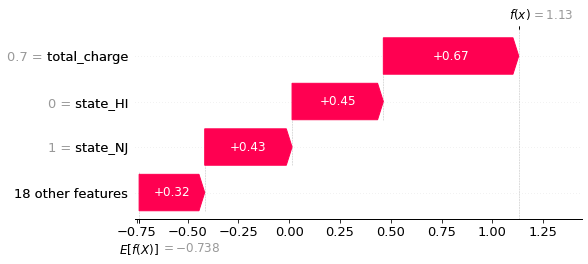

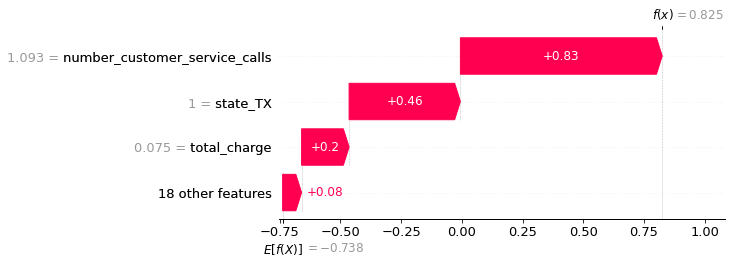

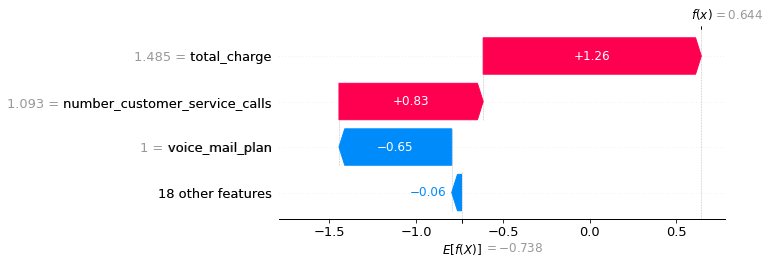

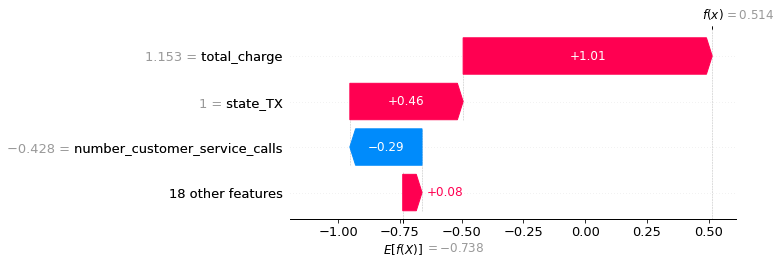

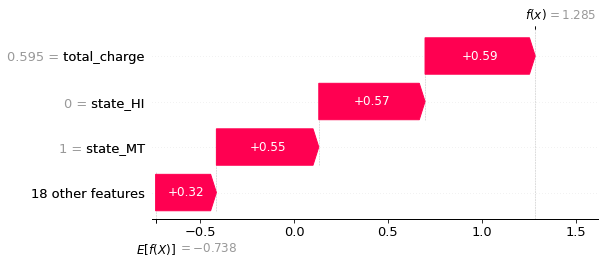

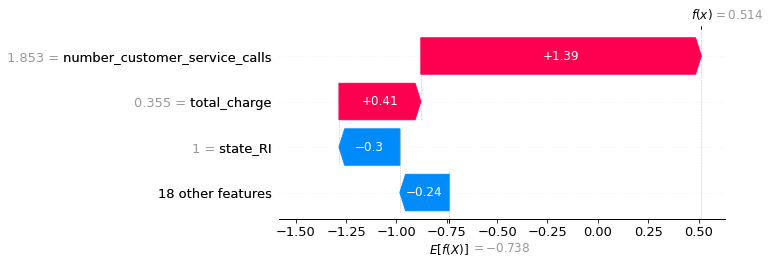

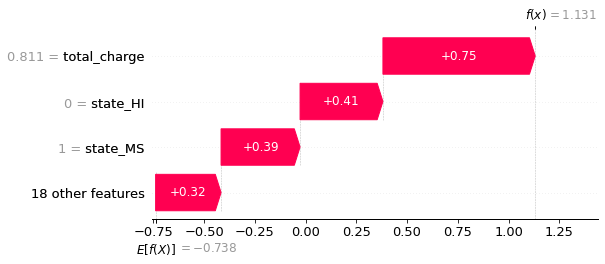

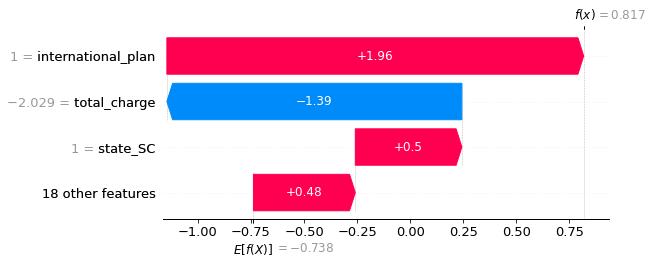

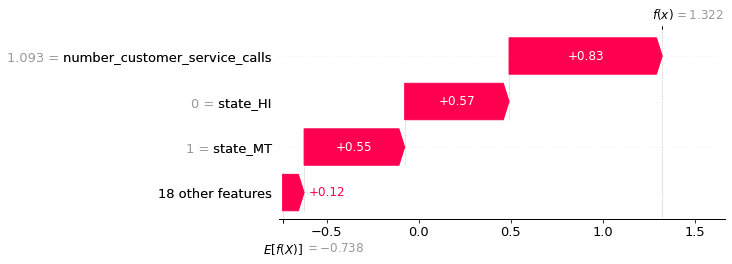

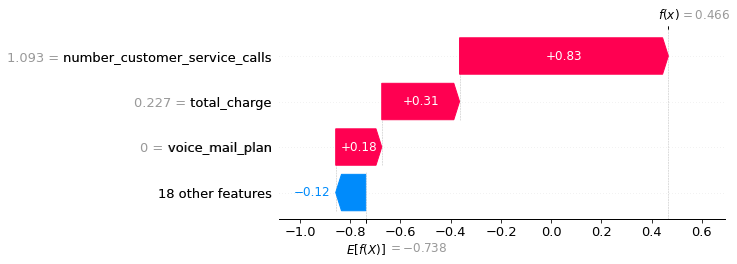

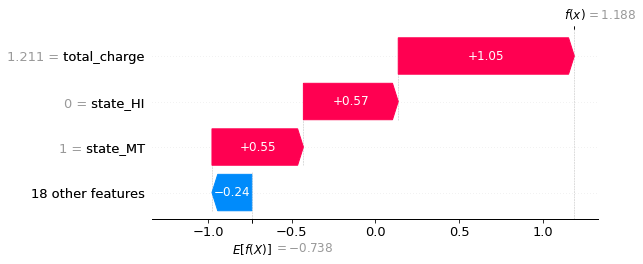

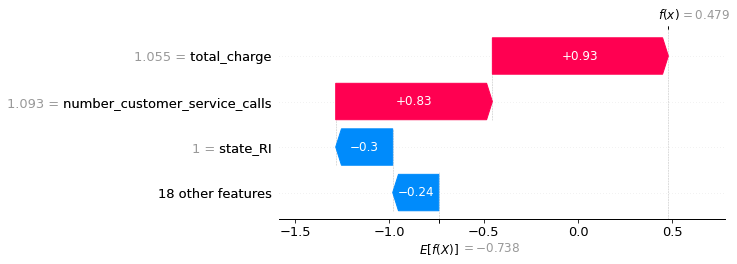

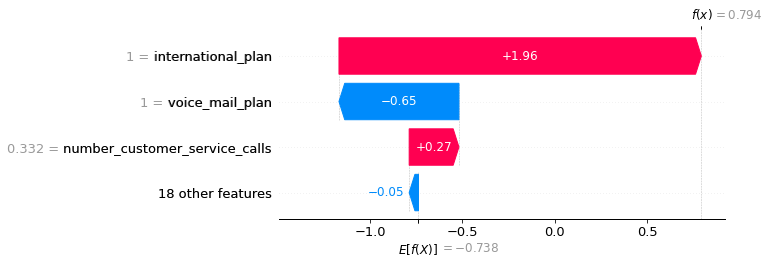

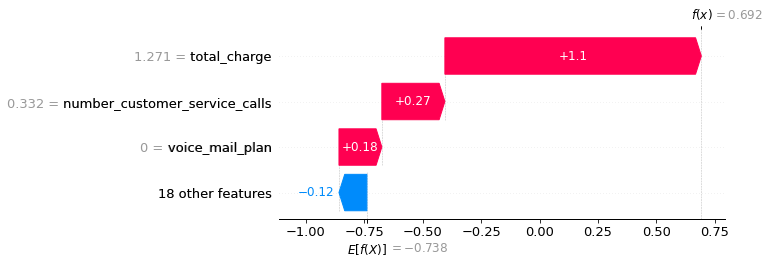

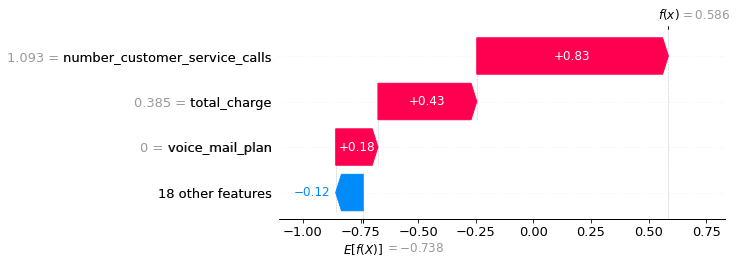

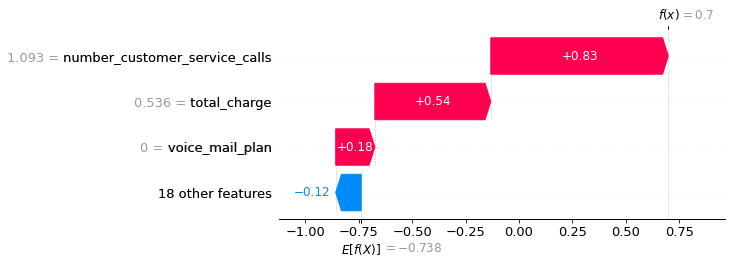

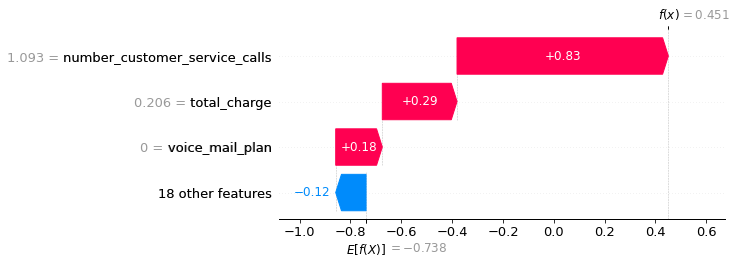

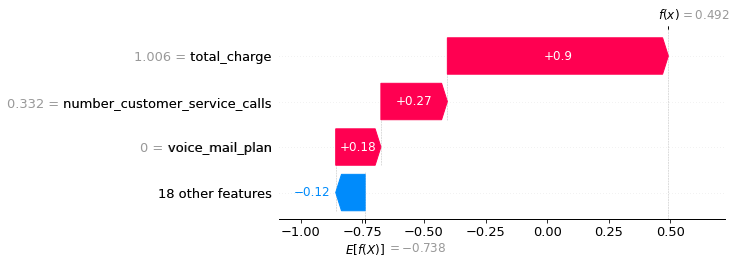

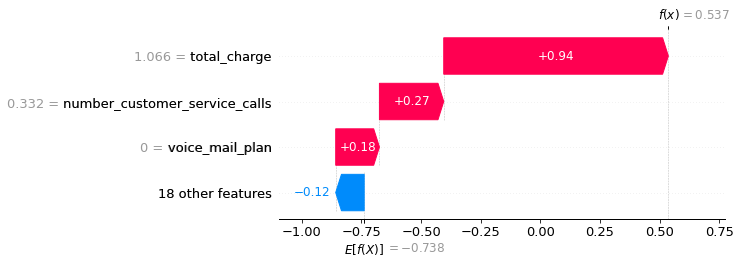

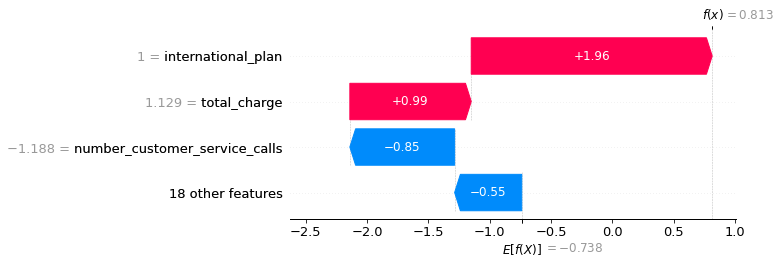

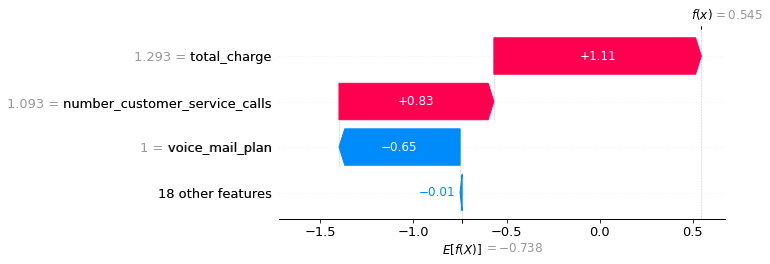

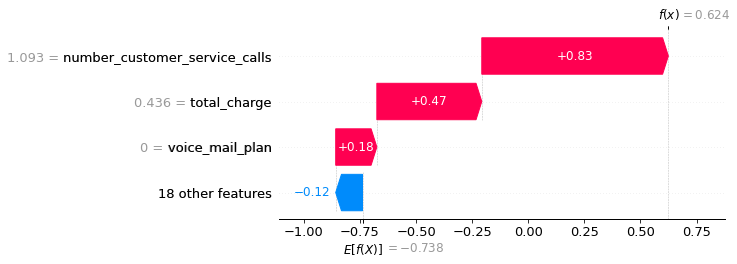

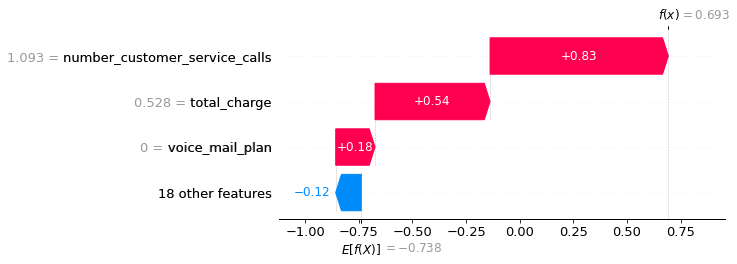

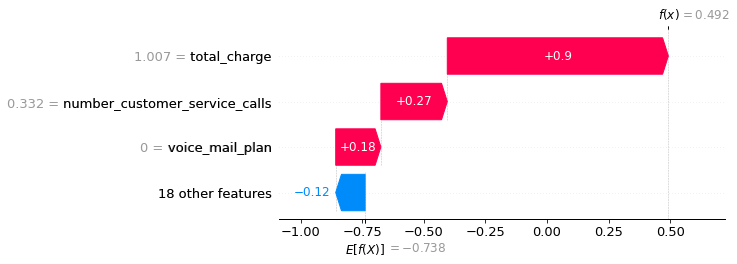

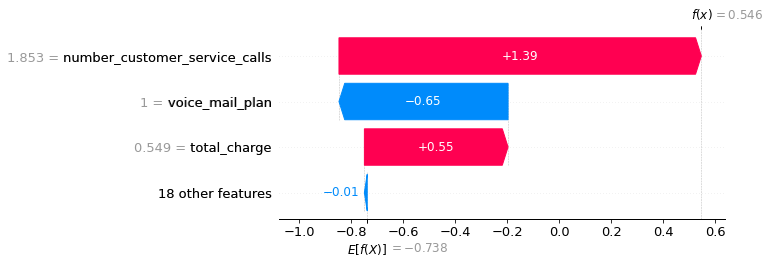

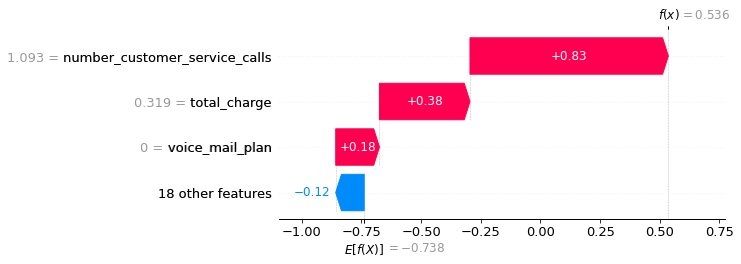

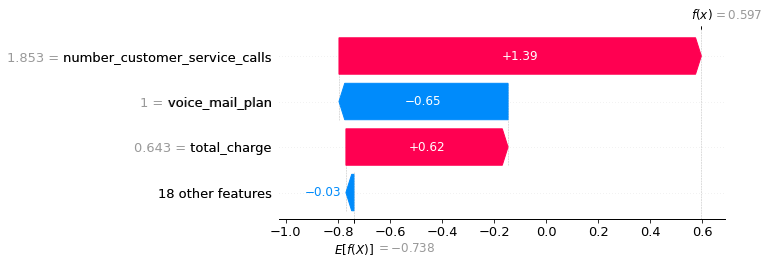

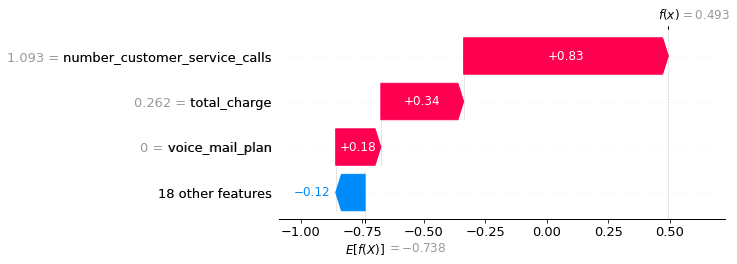

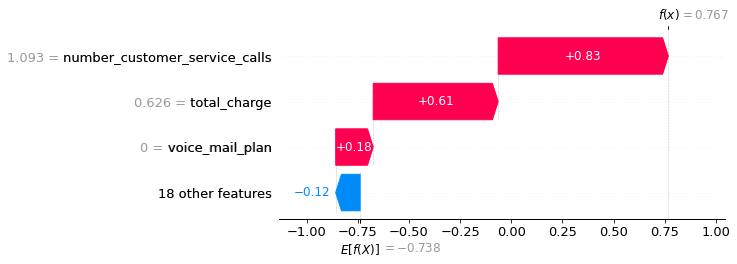

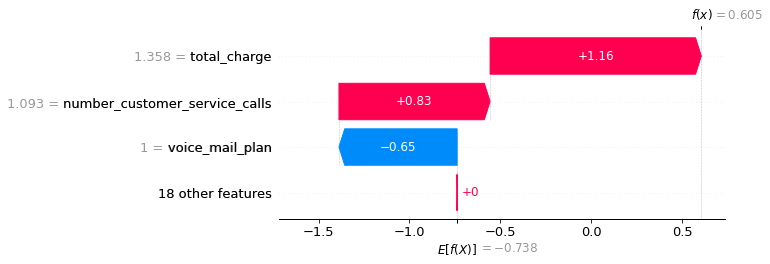

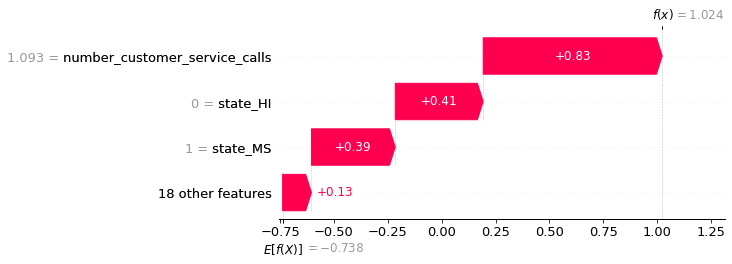

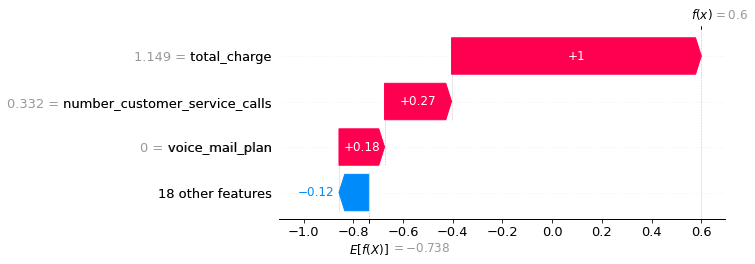

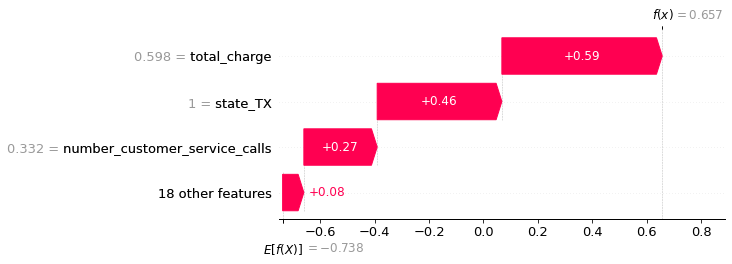

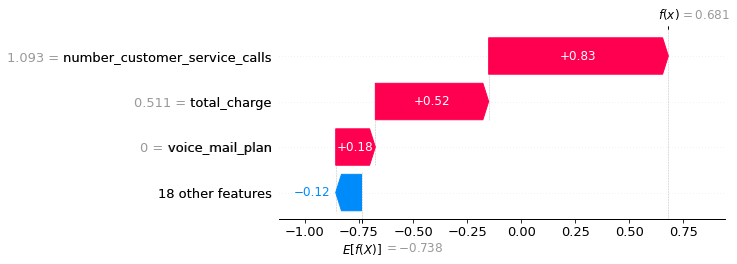

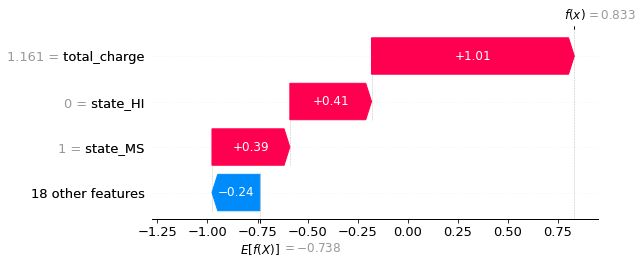

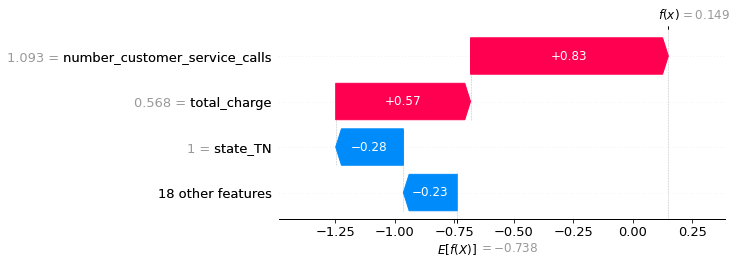

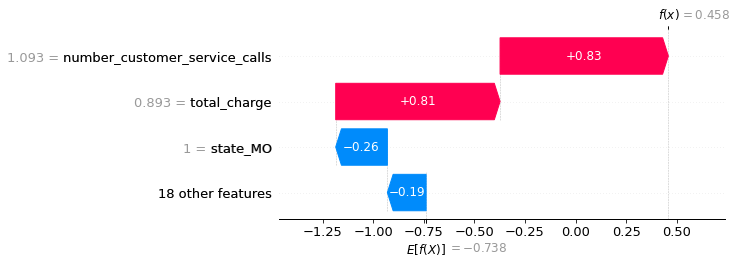

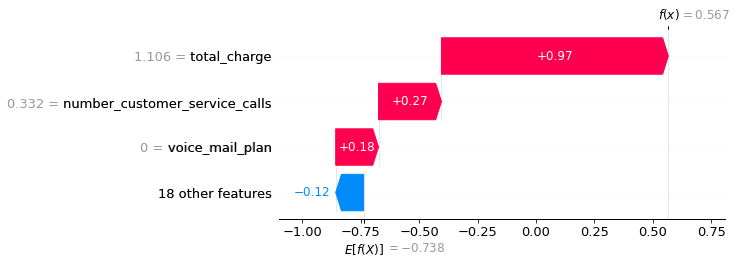

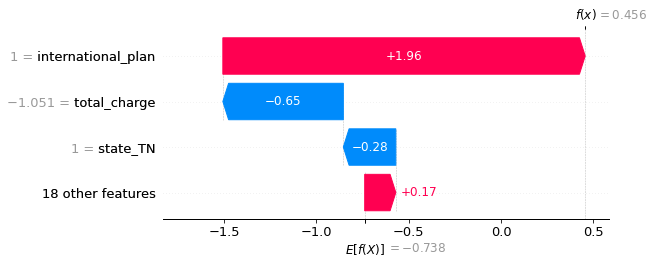

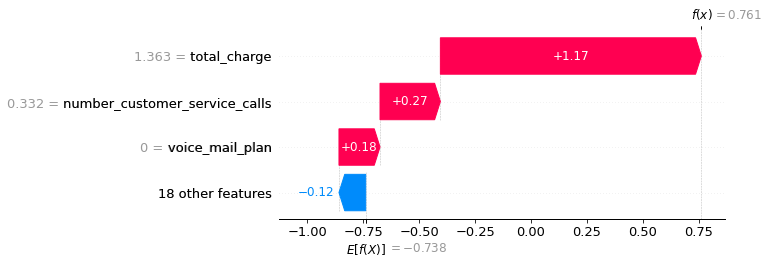

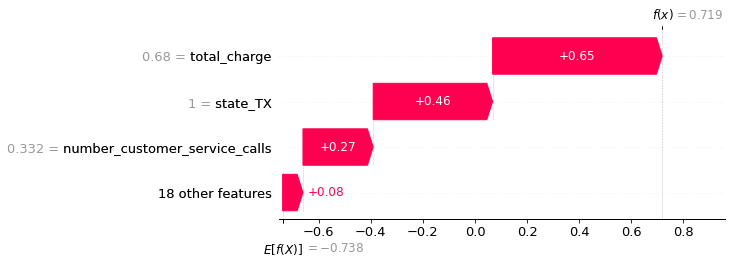

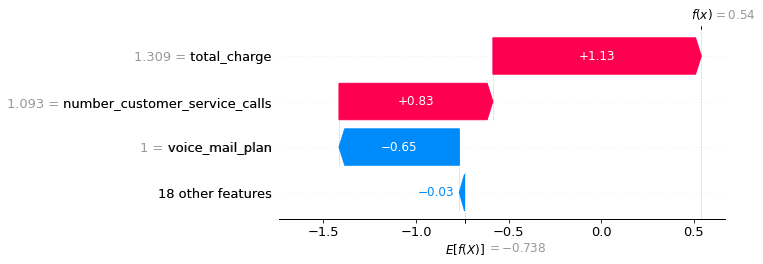

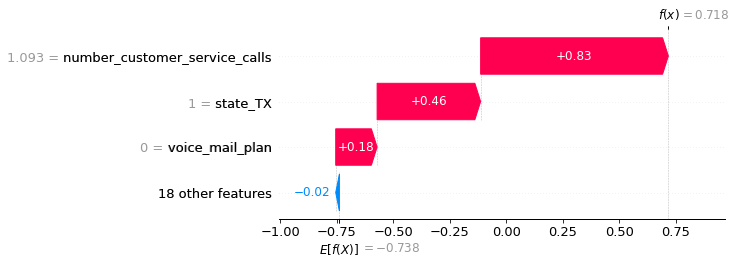

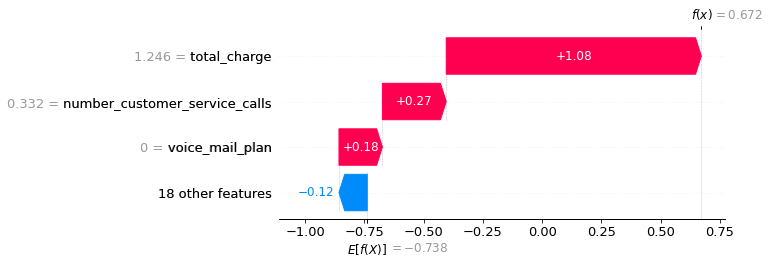

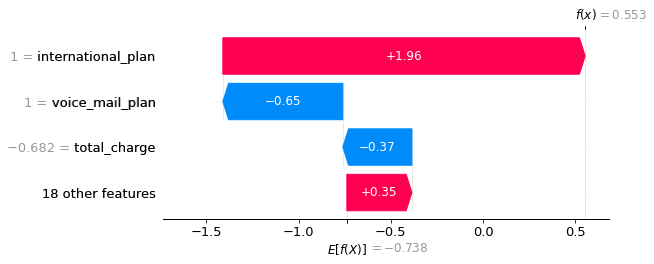

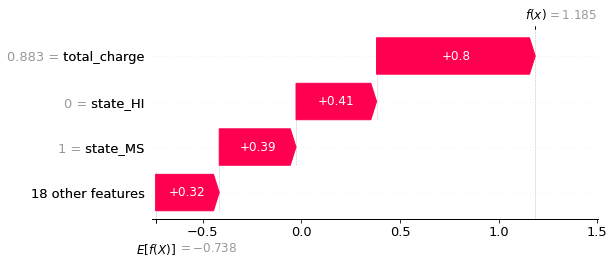

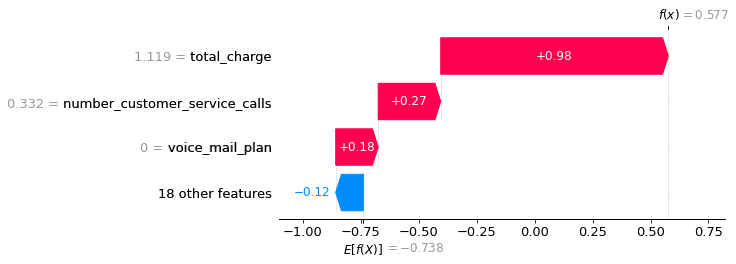

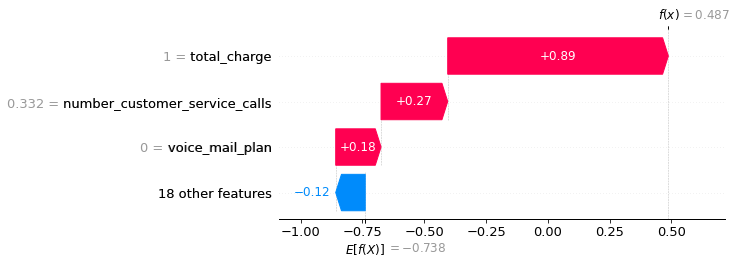

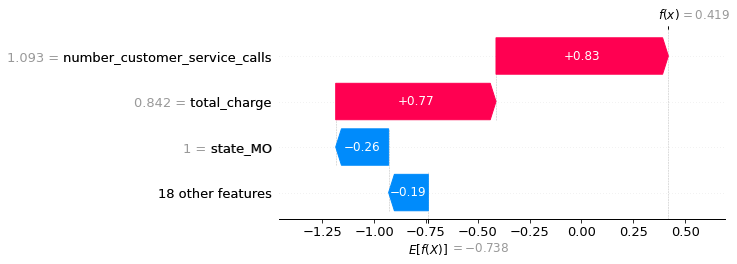

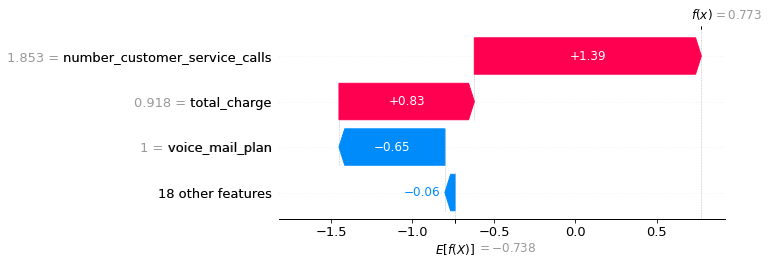

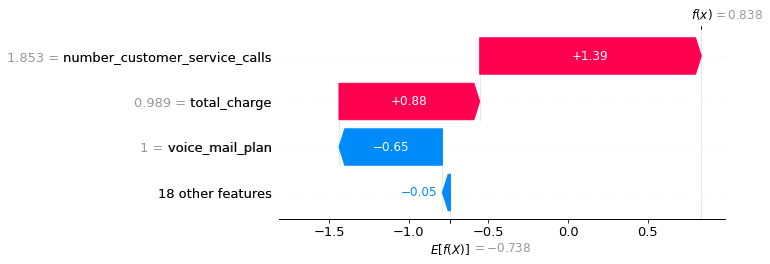

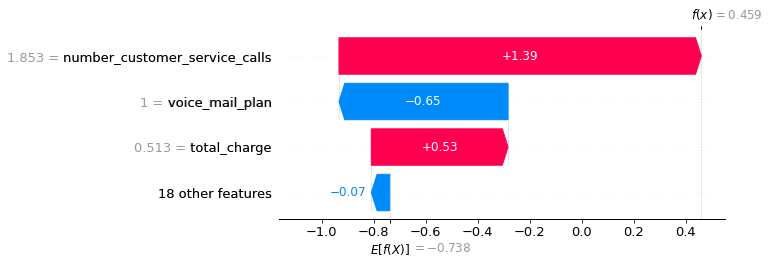

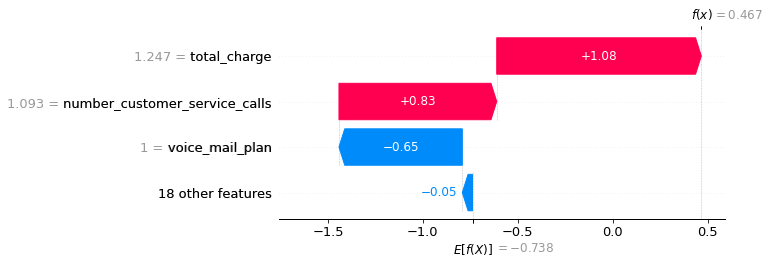

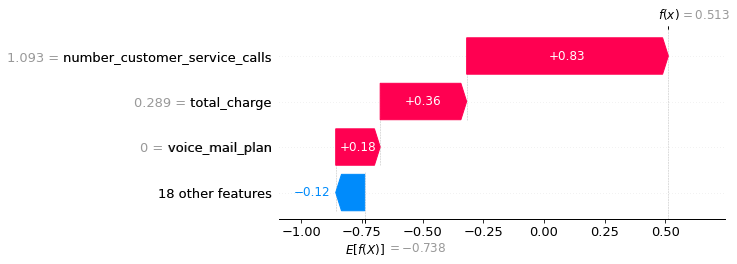

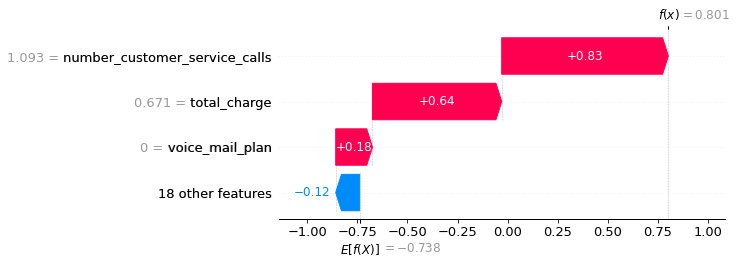

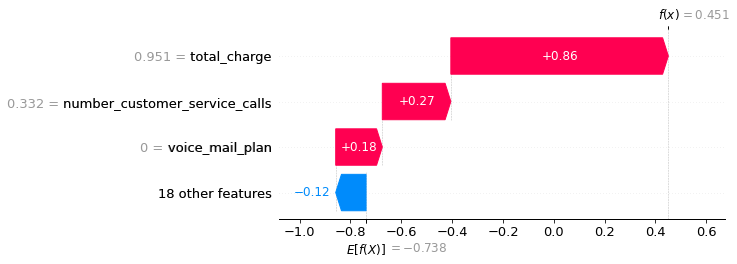

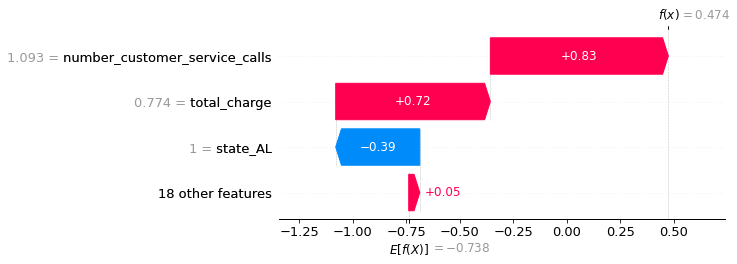

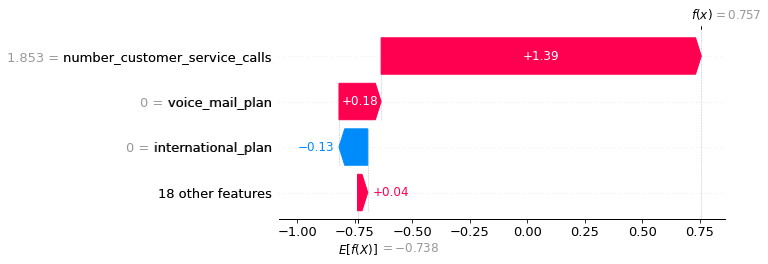

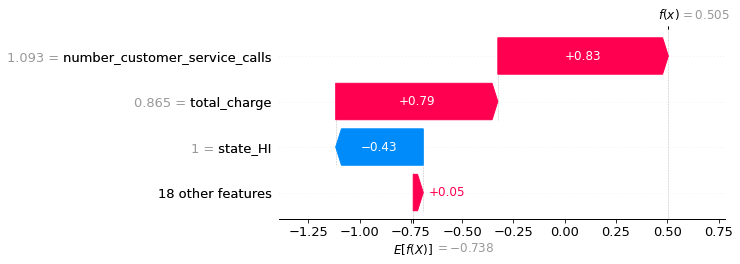

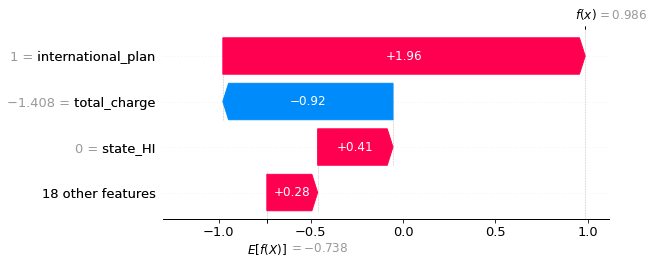

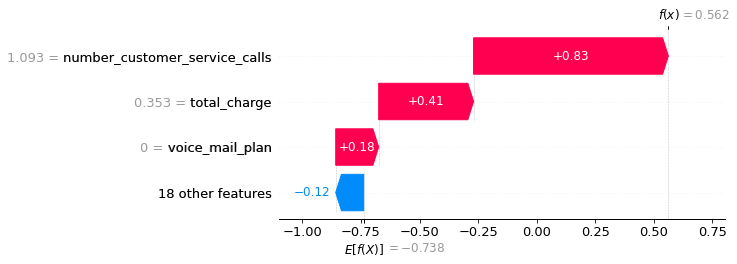

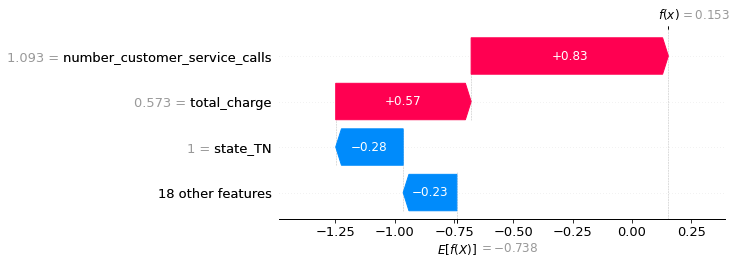

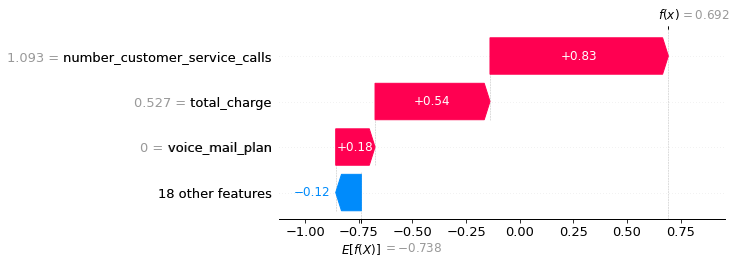

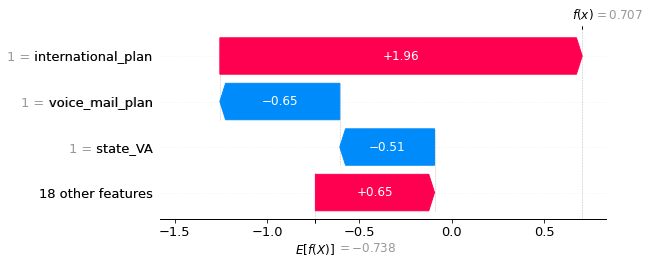

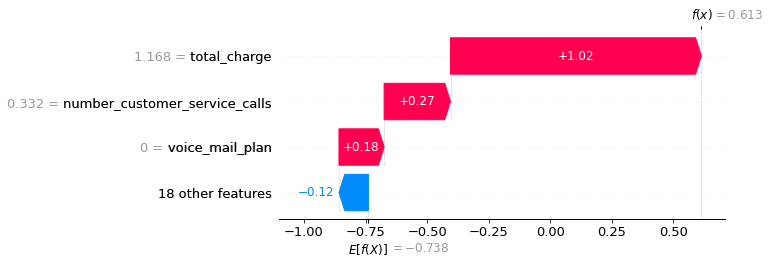

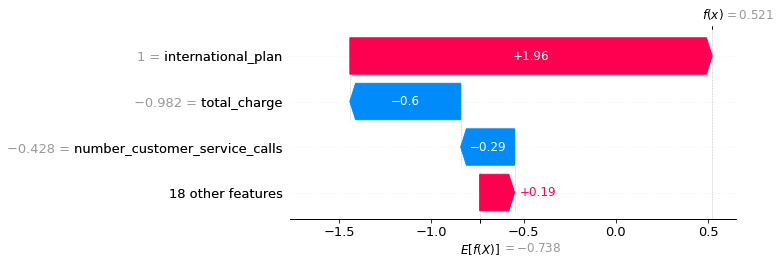

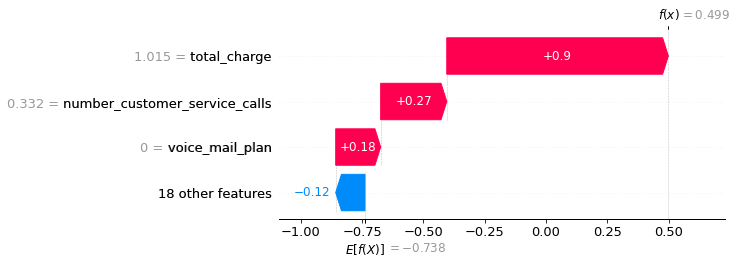

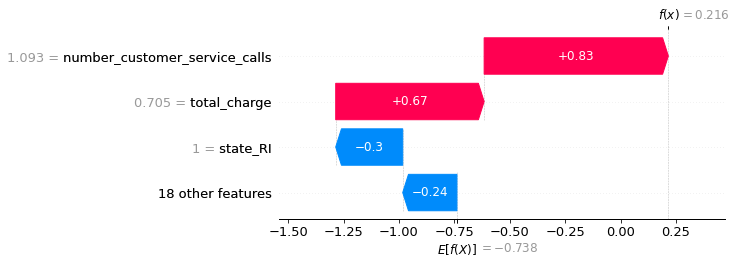

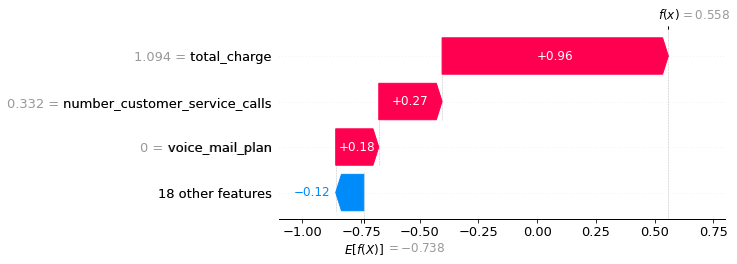

In [121]:
for index in error_instances[error_instances['groups'] =='60-70%'].index:
    shap.plots.waterfall(shap_values[index], max_display=4)

Overall, total_charge and number_customer_service_calls are the features that most impact the false positives in group '60-70%'.

Based on these observations, I will create a new feature called **'service_call_total_charge'**, which will be a combination of total_charge and number_customer_service_calls, as an attempt to better predict churn.

### 5.1 service_call_total_charge as a product of total_charge and number_customer_service_calls

service_call_total_charge will be created using the standardized features to avoid structural multicollinearity. For more information on this topic visit https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/.

In [122]:
scaler1 = StandardScaler()

Xtrain_newfeature = Xtrain[['total_charge','number_customer_service_calls']].prod(axis=1)
Xtest_newfeature = Xtest[['total_charge','number_customer_service_calls']].prod(axis=1)

Xtrain['service_call_total_charge'] = scaler1.fit_transform(np.array(Xtrain_newfeature).reshape(-1,1))
Xtest['service_call_total_charge'] = scaler1.transform(np.array(Xtest_newfeature).reshape(-1,1))

### Model6 - Logistic Regression with ref_features +  service_call_total_charge + regularization

In [123]:
tuned_param = {'C': [0.001,0.005,0.01,0.05,0.1,0.3,1]}

feature_m6 = list(feature_m5).copy()
feature_m6.append('service_call_total_charge')

# Grid Search
grid_search = GridSearchCV(estimator = LogisticRegression(class_weight='balanced'), 
                     param_grid = tuned_param, 
                     scoring = 'f1', return_train_score = True,     
                     cv = StratifiedKFold(5), n_jobs= -1).fit(Xtrain[feature_m6], ytrain)

In [124]:
model6 = grid_search.best_estimator_
model6

LogisticRegression(C=0.3, class_weight='balanced')

In [125]:
grid_search.best_score_

0.5541337663796033

In [126]:
title = 'Model6 performance in train and test'

plot_metrics_train_test(Xtrain[feature_m6],ytrain,Xtest[feature_m6],ytest,model6, title)

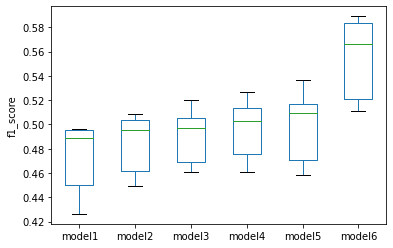

In [127]:
results = cross_val_train(model6, Xtrain, ytrain, feature_m6, 'f1', 5, results)

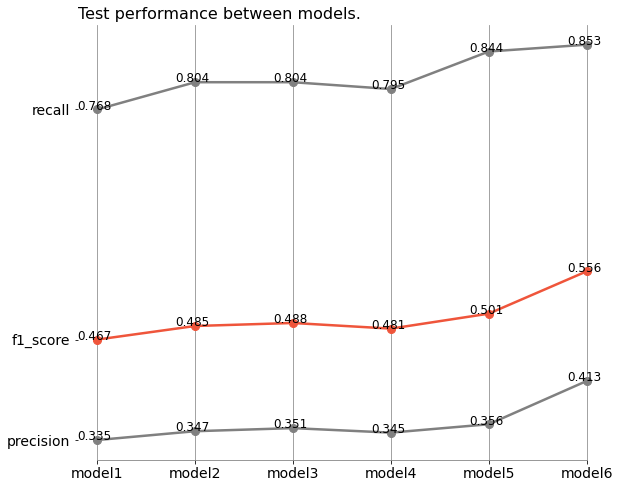

In [128]:
models = [model1,model2,model3, model4, model5,model6]
metrics = ['recall','f1_score','precision']
title = 'Test performance between models.'
features= features= [feature_m1,feature_m2,feature_m3,feature_m4,feature_m5,feature_m6]

slopegraph(Xtest, ytest, models, features,title, metrics)

There is a significant improvement in the model when feature 'total_charge' and 'number_customer_service_calls' are combined. Precision increased indicating that the false positive rate has decreased, the model is able to detect churn better. Now, since these metrics depends on the threshold, let's find the best threshold for this model and print the confusion matrix.

In [129]:
df_fscore, opt_threshold = best_threshold(Xtest[feature_m6], ytest, model6)
print('The best threshold for model 6 is ', np.round(opt_threshold,3))
print('Metrics under the best threshold')
df_fscore[df_fscore['fscore']==df_fscore['fscore'].max()]

The best threshold for model 6 is  0.656
Metrics under the best threshold


,threshold,precision,recall,fscore,accuracy
1385,0.656047,0.621514,0.696429,0.656842,0.90222


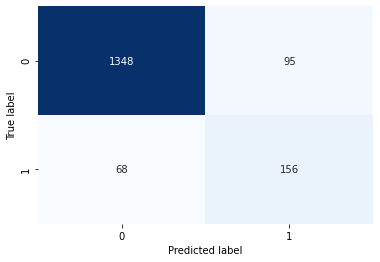

In [130]:
ypred = model6.predict_proba(Xtest[feature_m6])[:,1]

data = {'Reference':ytest, 'Prediction': np.round(ypred >= opt_threshold)}
df = pd.DataFrame(data)
confusion_matrix = pd.crosstab(df['Reference'], df['Prediction'].astype('int'), rownames=['True label'], 
                               colnames=['Predicted label'])
sns.heatmap(confusion_matrix, cmap = 'Blues', annot=True, fmt='g', cbar=False)
plt.show()

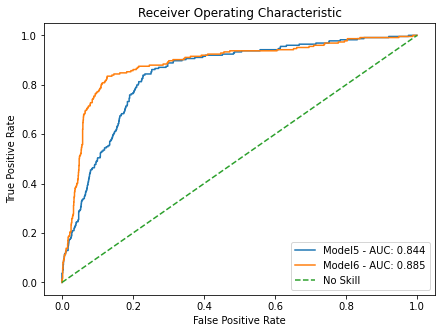

In [132]:
predictions = [model5.predict_proba(Xtest[feature_m5]),
              model6.predict_proba(Xtest[feature_m6])]
labels = ['Model5','Model6']
_ = roc_plot(predictions, labels, ytest)

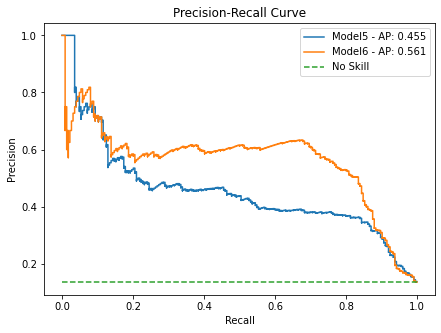

In [133]:
_ = prc_plot(predictions, labels, ytest)

## 6. Final Considerations

Model6 was able to correctly label 62% of all positive results using the best threshold, while model5 correctly labeled only 35%. 70% of the positive instances were recovered in model6, against 75% in model5. However, model6 have a better balance between precision and recall, returning less false positives, presenting an accuracy of 90%. These improvements were achievied by adding a new feature 'service_call_total_charge' to the model, a combination of total_charge and number_customer_service_calls, two features that most impacted the model.

If the performance of the model is in accordance with the business demands, it could be used in production, otherwise more work should be done to improve it. I will considered the job done.